In [ ]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

import numpy as np
import tqdm
import os

%load_ext autoreload
%autoreload 2

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/ctxcore/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# J comparison of gene networks from human interactome, cellmaps, omnipath,


In [4]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data"  #

In [5]:
! wget --no-check-certificate -O $LOC/RF2-PPI.gz https://conglab.swmed.edu/humanPPI/downloads/RF2-PPI_scores.gz
! wget --no-check-certificate -O $LOC/DCA_scores.gz https://conglab.swmed.edu/humanPPI/downloads/DCA_scores.gz

--2025-11-12 14:23:22--  https://conglab.swmed.edu/humanPPI/downloads/RF2-PPI_scores.gz
Resolving maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)... 192.168.148.66
Connecting to maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)|192.168.148.66|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 443540479 (423M) [application/x-gzip]
Saving to: ‘/pasteur/appa/scratch/jkalfon/data/spcrint_data/RF2-PPI.gz’

/pasteur/appa/scrat 100%[===================>] 422.99M  25.6MB/s    in 17s     

2025-11-12 14:23:40 (24.3 MB/s) - ‘/pasteur/appa/scratch/jkalfon/data/spcrint_data/RF2-PPI.gz’ saved [443540479/443540479]

--2025-11-12 14:23:41--  https://conglab.swmed.edu/humanPPI/downloads/DCA_scores.gz
Resolving maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)... 192.168.148.66
Connecting to maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)|192.168.148.66|:3128... connected.
Proxy request sent, awaiting r

In [6]:
res = pd.read_csv(
    LOC+"/RF2-PPI.gz",
    sep="\t",
    skiprows=7,
    header=None,  # nrows=100_000_000
)
res.columns = ["Pair", "RF2-PPI_interaction_probability", "Source"]

In [8]:
import bionty as bt

<Axes: xlabel='RF2-PPI_interaction_probability', ylabel='Count'>

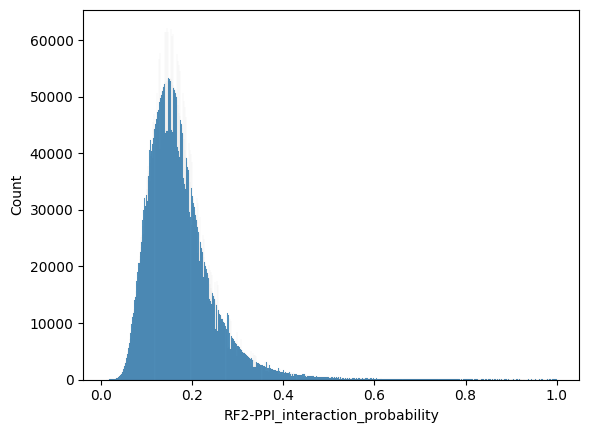

In [ ]:
sns.histplot(res["RF2-PPI_interaction_probability"])

In [9]:
prot_to_gene = {
    i["uniprotkb_id"]: i["gene_symbol"] for k, i in bt.Protein.public().df().iterrows()
}
genes = []
for i in res.Pair:
    a, b = i.split("_")
    genes.append([prot_to_gene.get(a, ""), prot_to_gene.get(b, "")])

res[["geneA", "geneB"]] = genes

→ connected lamindb: jkobject/scprint2


In [14]:
res = res[~res["geneA"].isna() & ~res["geneB"].isna()]

In [ ]:
res.to_parquet(LOC+"/RF2-PPI.parquet")

In [27]:
THRESHOLD = 0.4

In [28]:
humaninter_s = set(res[res["RF2-PPI_interaction_probability"] > THRESHOLD]['geneA'].str.cat(res[res["RF2-PPI_interaction_probability"] > THRESHOLD]['geneB'], sep="_").tolist())

In [29]:
len(humaninter_s)

765410

In [30]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name
gwps = gwps.extract_links()

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:657: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc.obs["organism_ontology_term_id"] = "NCBITaxon:9606"


In [31]:
omni = get_GT_db("omnipath")
collectri = get_GT_db("collectri")

In [32]:
omni_s = set([s + "_" + t for s, t in omni.iloc[:, :2].values])
collectri_s = set([s + "_" + t for s, t in collectri.iloc[:, :2].values])
gwps_s = set([s + "_" + t for s, t in gwps.iloc[:, :2].values])

In [33]:
# getting U2OS cell map data
import json

try:
    import ndex2
except ImportError:
    os.system("uv pip install ndex2")
    import ndex2
from ndex2.cx2 import RawCX2NetworkFactory, CX2NetworkXFactory
from ndex2.cx2 import CX2NetworkPandasDataFrameFactory

# Create NDEx2 python client
client = ndex2.client.Ndex2()

# Create CX2Network factory
factory = RawCX2NetworkFactory()

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
# https://www.ndexbio.org/viewer/networks/669f30a3-cee6-11ea-aaef-0ac135e8bacf
client_resp = client.get_network_as_cx2_stream("95bc75d5-d1d1-11ee-8a40-005056ae23aa")

# Convert downloaded network to CX2Network object
net_cx = factory.get_cx2network(json.loads(client_resp.content))

# Display information about network and output 1st 100 characters of CX2
print("Name: " + net_cx.get_name())
print("Number of nodes: " + str(len(net_cx.get_nodes())))
print("Number of nodes: " + str(len(net_cx.get_edges())))

# Creating an instance of CX2NetworkPandasDataFrameFactory
factory = CX2NetworkPandasDataFrameFactory()

# Converting CX2Network to DataFrame
cellmap = factory.get_dataframe(net_cx)

Resolved 15 packages in 1.40s
Prepared 3 packages in 1.34s
Installed 3 packages in 1.57s
 + ijson==3.4.0.post0
 + ndex2==3.11.0
 + requests-toolbelt==1.0.0


Name: U2OS AP-MS network
Number of nodes: 7543
Number of nodes: 36842


In [34]:
cellmap_s = set([s + "_" + t for s, t in cellmap.iloc[:, [2, 4]].values])

In [35]:
print("number of edges in gwps: ", len(gwps_s))
print("number of edges in omni: ", len(omni_s))
print("number of edges in collectri: ", len(collectri_s))
print("number of edges in humaninter: ", len(humaninter_s))
print("number of edges in cellmap: ", len(cellmap_s))

number of edges in gwps:  1115036
number of edges in omni:  273556
number of edges in collectri:  41595
number of edges in humaninter:  765410
number of edges in cellmap:  36842


In [ ]:
cellmap_s

{'NPM3_SENP5',
 'LRCH1_DOCK7',
 'NPTN_DSTYK',
 'DHX8_USP42',
 'ZSCAN5A_RRP7A',
 'PBXIP1_NDUFA2',
 'CD68_FAM114A2',
 'GALNS_SLC25A16',
 'RIC3_CEP192',
 'TTC23L_EFCAB7',
 'POP7_LAGE3',
 'TMEM88_SLC12A4',
 'PSMB7_PSMD6',
 'TERF1_ACD',
 'FBXW7_FBXO45',
 'SPIN1_TOPORS',
 'HSPA8_IRF2BP2',
 'HMGA1_TRIP12',
 'ARHGEF35_CCZ1B',
 'TNFRSF6B_ANKRD50',
 'DCAF8_PIP5K1A',
 'COPS3_DDB2',
 'EPB41L5_PRCP',
 'IFT81_IFT74',
 'HSP90AB1_DUSP14',
 'YWHAB_KCTD3',
 'S1PR3_ZDHHC5',
 'CHRNB1_BNIP1',
 'COMMD2_COMMD3',
 'FTL_SKA1',
 'CD27_DTYMK',
 'SIRT6_PML',
 'MUCL1_PDIA5',
 'APLNR_ADGRG1',
 'FAM219A_MRE11',
 'IRF2BP1_RAB34',
 'HMGCL_PNPT1',
 'MFGE8_ENO3',
 'PYM1_ZC3H8',
 'PTH2R_OSMR',
 'TNFSF8_HAUS5',
 'AURKB_TBC1D9B',
 'CREB3_SOAT1',
 'TAX1BP3_AMER1',
 'CRCP_NUDT3',
 'RAB11B_NCKIPSD',
 'PEX7_RAB2B',
 'EGFL8_MPO',
 'RACK1_N4BP2',
 'EAF1_PIP5K1C',
 'SNRNP70_GEMIN5',
 'CCKBR_PIGO',
 'RAD23A_MPG',
 'SLC22A16_TMBIM6',
 'ZNRD2_MGA',
 'FBXW7_HAL',
 'C9orf40_TRAPPC10',
 'WASHC3_BLOC1S4',
 'XXYLT1_PDCD2L',
 'KBTBD7_EBI3

In [39]:
gwps_s

{'DERL1_POLR2B',
 'DOT1L_POLR1B',
 'TYMS_THEMIS2',
 'RARS_TP53I13',
 'WDR83OS_COX6B1',
 'HNRNPDL_EIF2B4',
 'SSB_XPR1',
 'CBX5_MED7',
 'FASN_HIPK1',
 'FCGRT_RPS9',
 'SSR2_RIOK1',
 'RSU1_DNAJC19',
 'PRC1_PTPN1',
 'MAP1B_SSRP1',
 'KPNB1_COPS4',
 'BBX_UXT',
 'HNRNPM_MCMBP',
 'BTF3_RTRAF',
 'ATP6V0A1_TOMM22',
 'MIF_COX7B',
 'UBE2F_OXA1L',
 'ABRAXAS1_UQCRQ',
 'NDUFB9_CUL1',
 'FAM20B_PGAM1',
 'CAPG_SUPT5H',
 'UFM1_ZNRD1',
 'MARCH7_EXOSC2',
 'TOMM22_PSMD2',
 'RO60_UPF2',
 'FDX2_TAF5',
 'TIMM50_RPL10',
 'NASP_DHDDS',
 'U2SURP_FCF1',
 'STT3A_TAF1',
 'FDFT1_NUMA1',
 'SEC11A_SUGP1',
 'GSTP1_NLE1',
 'RPL17_ANKRD11',
 'SNF8_TAF13',
 'APOE_UCHL5',
 'MRPL1_PPP1R8',
 'DKC1_ATP5PO',
 'UBA52_MRPS21',
 'GLRX5_METAP2',
 'UBL5_NAA15',
 'AC139493.2_EIF1AX',
 'TELO2_ALDOA',
 'RPS29_CHMP3',
 'NOL8_GATA1',
 'RNF126_MAX',
 'FDPS_SUPT20H',
 'PSME1_EXOSC2',
 'MICU2_MED30',
 'SQLE_DNAJA3',
 'SUCLG1_NUDCD1',
 'TUBG1_SMC1A',
 'SEC31A_SUPT20H',
 'NDRG3_MED7',
 'EMP3_PSMA2',
 'MAP1B_MAP1B',
 'ARFGAP2_EIF6',
 'GAL_CAMLG

In [ ]:
humaninter_s

{'MSMO1_ARL6IP6',
 'CHRNB1_CHRND',
 'KRT15_KRT28',
 'ZNF655_EVL',
 'SDC3_SDC2',
 'KPNA2_FAM204A',
 'RSL1D1_DDX18',
 'MRPL50_MRPL15',
 'ADAR_TASOR2',
 'TFAP2A_TFAP2C',
 'LOC100653049_KRT32',
 'IGKV3-7_IGLL1',
 'UBE2W_OTUB1',
 'HGS_STAM',
 'SFRP5_C6orf120',
 'BCL2L11_BCL2',
 'OR2AK2_PPP1R14C',
 'IFT81_IFT74',
 'KRT3_KRT25',
 'TCP1_CDC37',
 'EPHA8_EFNA3',
 'LYAR_GAR1',
 'MT-CO1_MT-ND3',
 'CAVIN4_CAVIN3',
 'COMMD2_COMMD3',
 'DCTN1_HSPA12B',
 'NDUFS6_FOXRED1',
 'CLNK_GTSF1L',
 'MT-ND2_NDUFAF1',
 'CIT_DCTN1',
 'KRT19_ERC1',
 'PARD3_BRPF3',
 'IGLV10-54_IGLL1',
 'PTPN6_C8orf33',
 'SIRT6_ABCF2',
 'SEC61G_SEC61B',
 'FLT4_KDR',
 'TRAPPC6B_TRAPPC1',
 'APOBEC1_KRTAP6-2',
 'PTPRZ1_CYP3A7',
 'MRPL21_MRPL20',
 'NXT2_NXF1',
 'NFE2L2_BRPF3',
 'GSTA2_GSTP1',
 'FIP1L1_SIRT6',
 'NKX6-1_FOXA2',
 'S100PBP_PCED1A',
 'ASXL2_BAP1',
 'TUBA3E_TUBB1',
 'CLEC4D_TIMD4',
 'NKAP_FAM50B',
 'IGLV11-55_IGLL1',
 'MIER1_HDAC2',
 'RFXANK_CLK3',
 'ARHGEF10_ARHGEF10L',
 'OR51L1_CD300A',
 'IGLL5_IGKV1D-16',
 'KRT36_KRT39',
 'T

In [37]:
! uv pip install venn

Resolved 12 packages in 1.87s                                        
Prepared 1 package in 57.44s                                             
Installed 1 package in 565ms                                
 + venn==0.1.3


<Axes: >

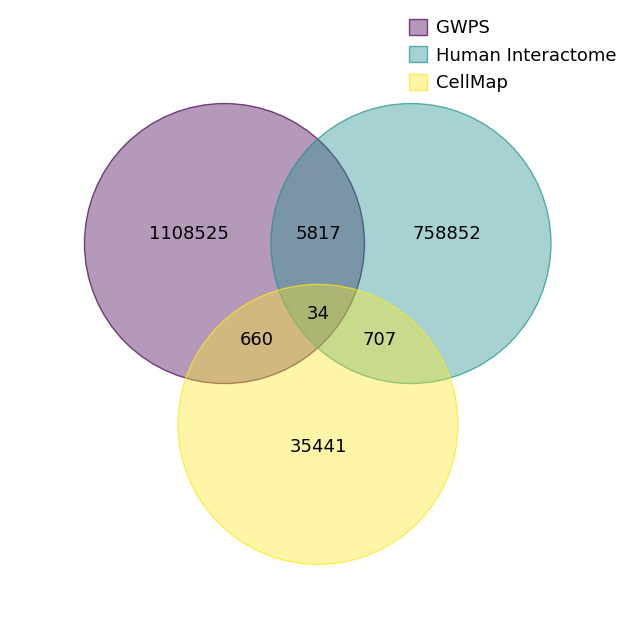

In [40]:
from venn import venn

# Create a dictionary of sets
sets = {
    #'OmniPath': omni,
    #'CollecTRI': collectri,
    "GWPS": gwps_s,
    "Human Interactome": humaninter_s,
    "CellMap": cellmap_s,
}

venn(sets)

<Axes: >

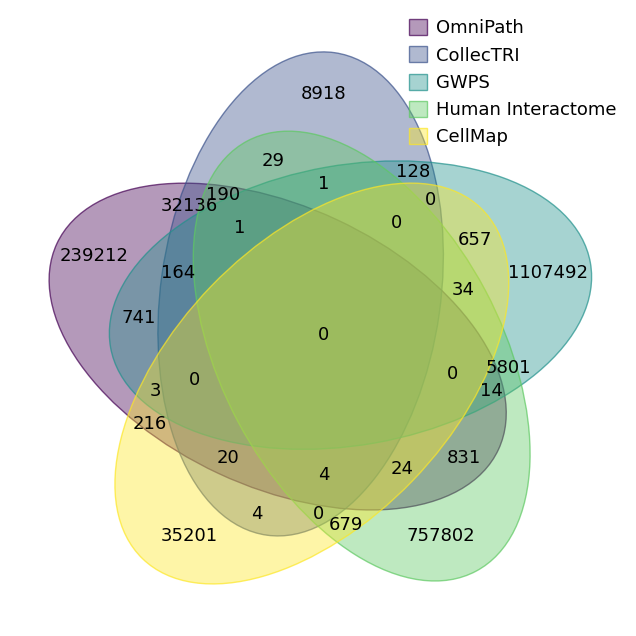

In [46]:
sets = {
    "OmniPath": omni_s,
    "CollecTRI": collectri_s,
    "GWPS": gwps_s,
    "Human Interactome": humaninter_s,
    "CellMap": cellmap_s,
}

venn(sets)

<Axes: >

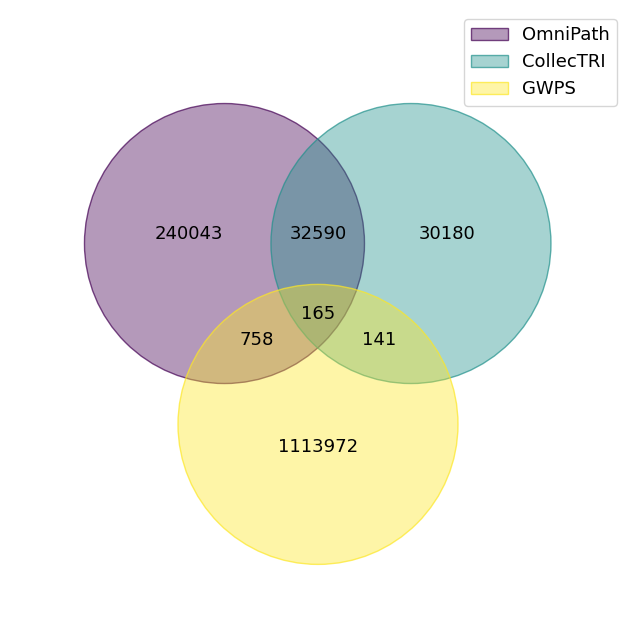

In [ ]:
sets = {
    "OmniPath": omni_s,
    "CollecTRI": collectri_s,
    "GWPS": gwps_s,
    #'Human Interactome': humaninter,
    #'CellMap': cellmap
}

venn(sets)

## predict human interactome network


In [44]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from huggingface_hub import hf_hub_download

from scprint import scPrint
from scprint.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
import scanpy as sc
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import joblib

%load_ext autoreload
%autoreload 2 

import torch

torch.set_float32_matmul_precision("medium")

/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
model_checkpoint_file = "../models/ji9krimq.ckpt"  # w937u4o1.ckpt"

In [45]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [ ]:
from scdataloader.utils import load_genes
import anndata as ad
import pandas as pd
import bionty as bt
from grnndata import from_adata_and_longform

# Load gene names
genes = load_genes("NCBITaxon:9606")

# Create empty anndata with gene names
empty_adata = ad.AnnData(X=np.zeros((1, len(genes))), var=genes)
print(f"Created empty AnnData with {len(genes)} genes")
empty_adata.var["ensembl_id"] = empty_adata.var.index
empty_adata.var.set_index("symbol", inplace=True, drop=False)
gt_cm = from_adata_and_longform(empty_adata, cellmap.iloc[:, [2, 4]])
gt_inter = from_adata_and_longform(empty_adata, res[res["RF2-PPI_interaction_probability"] > THRESHOLD][['geneA', 'geneB', 'RF2-PPI_interaction_probability']], has_weight=True)

Created empty AnnData with 70116 genes


  0%|          | 0/766108 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [48]:
gt_inter = from_adata_and_longform(empty_adata, res[res["RF2-PPI_interaction_probability"] > THRESHOLD][['geneA', 'geneB', 'RF2-PPI_interaction_probability']], has_weight=True)

100%|██████████| 766108/766108 [06:51<00:00, 1859.66it/s]


In [54]:
gt_cm.var.index.name = "index"
gt_inter.var.index.name = "index"

In [55]:
gt_cm.write_h5ad(LOC + "/gt_cellmap.h5ad")
gt_inter.write_h5ad(LOC + "/gt_humaninter.h5ad")

In [56]:
# only dataset dropped
adata = sc.read(
    LOC + "/glio_smart_highdepth" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

adata.var["isTF"] = False
adata.var.loc[adata.var.feature_name.isin(grnutils.TF), "isTF"] = True
adata

  0%|          | 0.00/31.9M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 3589 × 22149
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered'

In [57]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata)

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 3589 renamining
filtered out 22 cells, 3567 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 47967 genes in the ontology but not present in the dataset
starting QC
Seeing 71 outliers (1.99% of total dataset):
done
AnnData object with n_obs × n_vars = 3567 × 70116
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_

In [60]:
adata.obs.cell_type.value_counts()

cell_type
myeloid cell                      1842
neoplastic cell                   1079
oligodendrocyte precursor cell     406
astrocyte                           88
oligodendrocyte                     81
vascular lymphangioblast            50
neuron                              21
Name: count, dtype: int64

In [ ]:
gwps = get_perturb_gt()

In [73]:
gwps.var.index = gwps.var.gene_name


In [78]:
adata.obs.cell_type.isin([celltype])

b97a414c-09c6-4609-8449-4bcc2c9453d3    False
d2c3f12e-8db6-4df1-9632-4c4e15c8d638    False
c3e7152e-5a0c-4e86-916d-fb13819178bb    False
1a62675c-f9bc-4935-87ec-7a81472d9168    False
f9800ce6-02a8-4563-a88e-521978c51c79    False
                                        ...  
4d66f651-7298-470c-9a7a-39c541488767    False
2808fd52-9da5-4249-b9d5-fca0535c0d84     True
d3b327af-b087-4716-b122-53da805bcb18    False
e3d704dc-b34f-4a69-86d3-d7cbb6e1d79a    False
275904c9-c443-4a43-8e5c-3095aa5fc557    False
Name: cell_type, Length: 3567, dtype: bool

In [82]:
adata = adata[(adata.X.sum(1) > 500)]

number of expressed genes in this cell type: 18832


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 64/64 [00:20<00:00,  3.12it/s]
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 8294400, sparsity: 1.0
loading GT,  collectri
intersection of 1112 genes
intersection pct: 0.38624522403612366
only tf:  False
using only tf:  0.38624522403612366
total true edges:  1600.0
precision:  0.0012939288856684437 
recall:  1.0 
random precision: 0.0012950935381307914


 92%|█████████▏| 118/128 [00:00<00:00, 587.49it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 583.20it/s]


Average Precision (AP):  0.0023844819820559074
Area Under Precision-Recall Curve (AUPRC):  0.0023515517610108233
EPR: 2.89554375


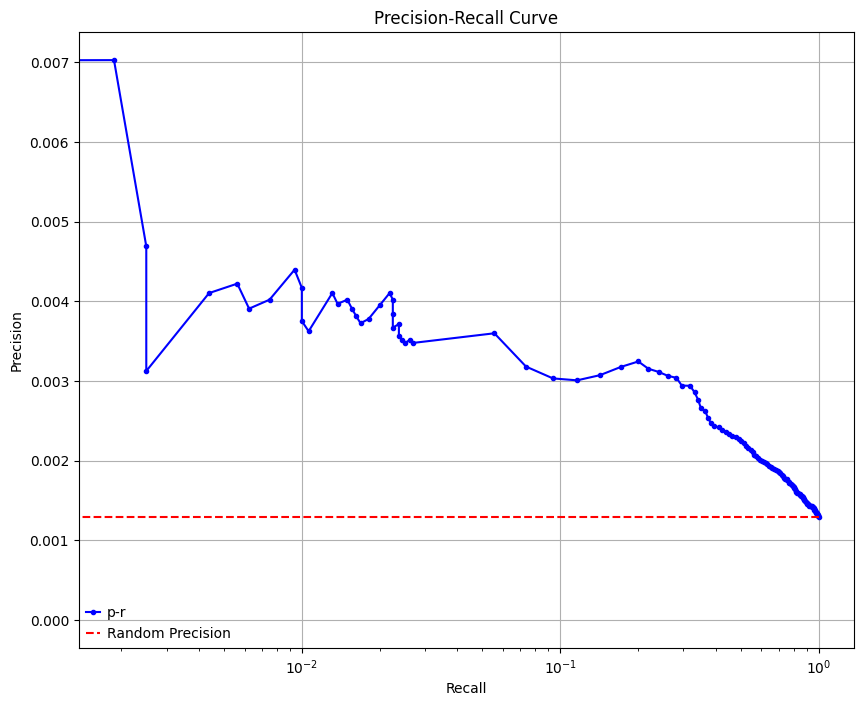

loading GT,  omnipath
intersection of 2086 genes
intersection pct: 0.7245571378951025
only tf:  False
using only tf:  0.7245571378951025
total true edges:  5100.0
precision:  0.001172037663315405 
recall:  1.0 
random precision: 0.0011725997916910958


 94%|█████████▍| 120/128 [00:00<00:00, 146.46it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 146.27it/s]


Average Precision (AP):  0.0022532868600549628
Area Under Precision-Recall Curve (AUPRC):  0.0022395127762862644
EPR: 5.016505190311419


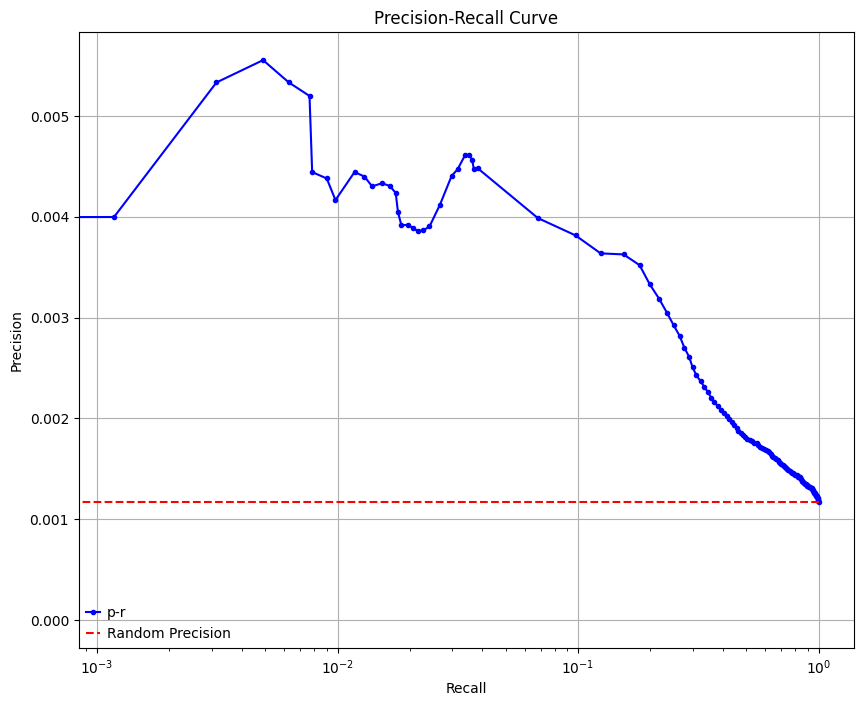

precision:  0.0010859056694979628 
recall:  1.0 
random precision: 0.0010862432217732187


 98%|█████████▊| 126/128 [00:00<00:00, 618.38it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 614.01it/s]


Average Precision (AP):  0.0009905605182477688
Area Under Precision-Recall Curve (AUPRC):  0.0009862116680630318
EPR: 1.4635995763836407


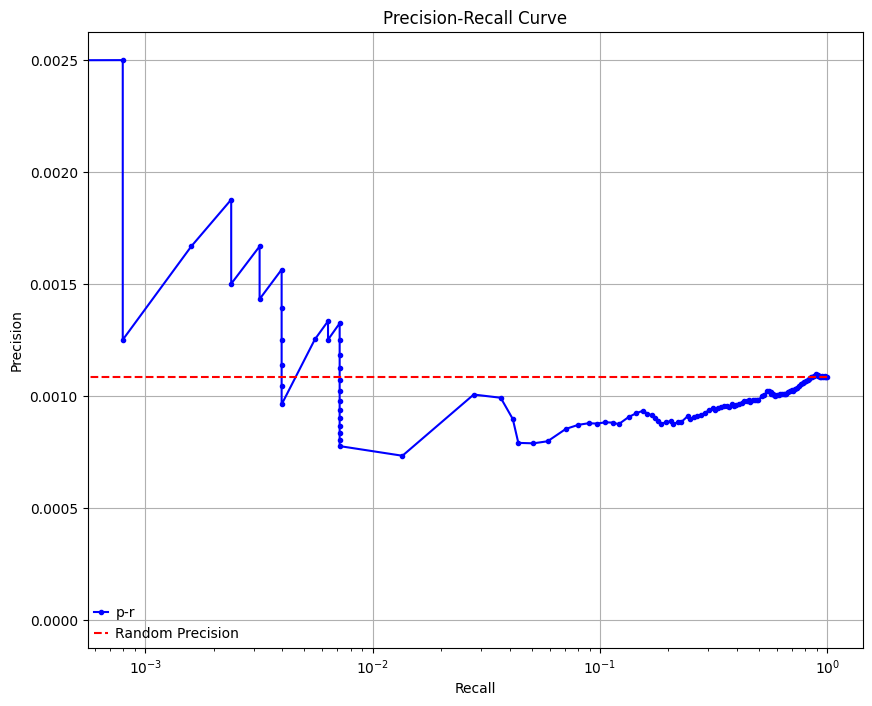

precision:  0.01924866716228692 
recall:  1.0 
random precision: 0.019262338090669226


 99%|█████████▉| 127/128 [00:00<00:00, 418.64it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 417.41it/s]


Average Precision (AP):  0.01957960627987488
Area Under Precision-Recall Curve (AUPRC):  0.019575465063865025
EPR: 0.7449586254559185


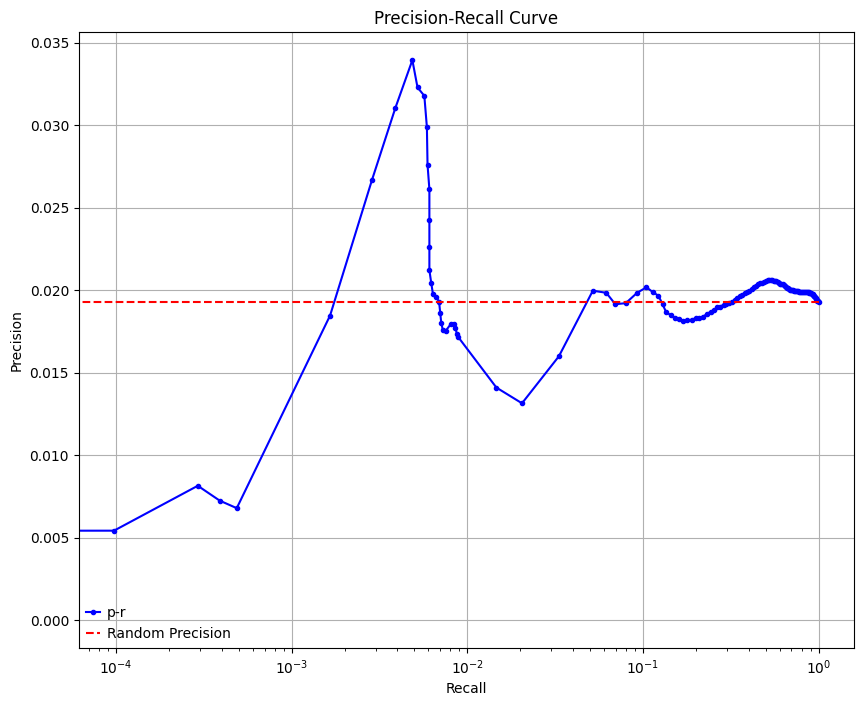

precision:  0.002134992600856161 
recall:  1.0 
random precision: 0.0021356562603528522


 98%|█████████▊| 126/128 [00:01<00:00, 67.03it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 66.92it/s]


Average Precision (AP):  0.0019365973966491191
Area Under Precision-Recall Curve (AUPRC):  0.0019357570056030208
EPR: 0.263648731079052


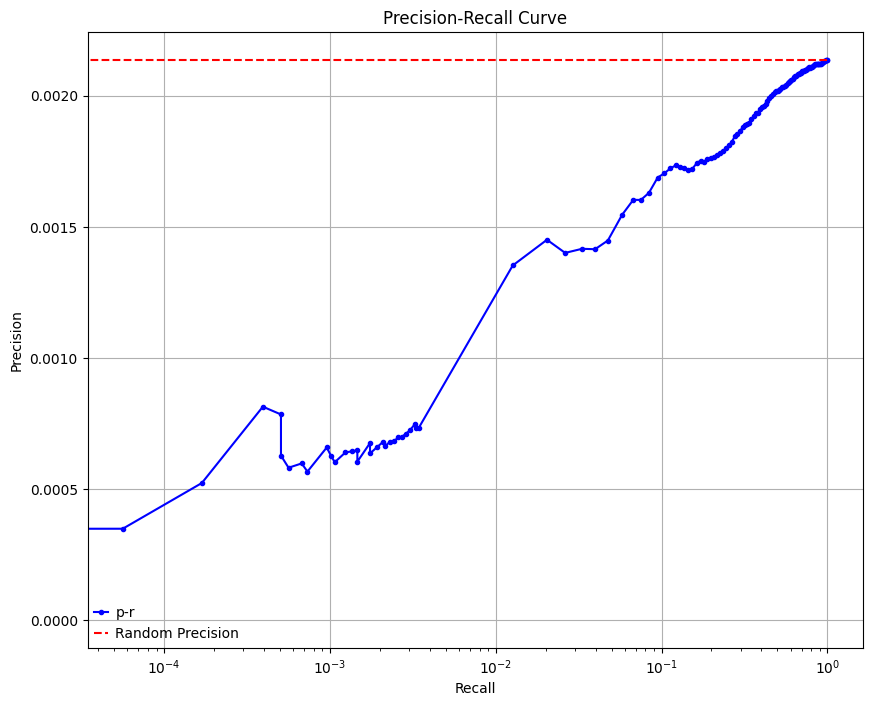

number of expressed genes in this cell type: 19502


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 64/64 [00:20<00:00,  3.15it/s]
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 8173881, sparsity: 1.0
loading GT,  collectri
intersection of 1187 genes
intersection pct: 0.4153254023792862
only tf:  False
using only tf:  0.4153254023792862
total true edges:  1759.0
precision:  0.0012484305900271758 
recall:  1.0 
random precision: 0.0012494832296477722


 81%|████████▏ | 104/128 [00:00<00:00, 513.44it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 513.12it/s]


Average Precision (AP):  0.001871824760264888
Area Under Precision-Recall Curve (AUPRC):  0.0018626793005657944
EPR: 0.9099839338401289


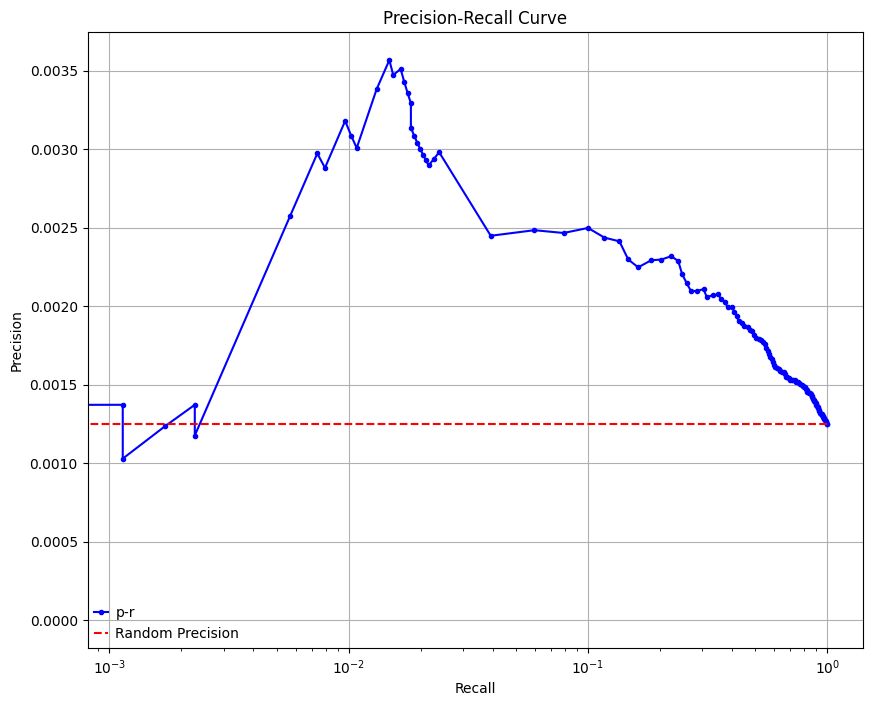

loading GT,  omnipath
intersection of 2020 genes
intersection pct: 0.7067879636109167
only tf:  False
using only tf:  0.7067879636109167
total true edges:  4052.0
precision:  0.0009930398980492108 
recall:  1.0 
random precision: 0.0009935317454479475


 88%|████████▊ | 112/128 [00:00<00:00, 159.14it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 159.43it/s]


Average Precision (AP):  0.0018293539972560986
Area Under Precision-Recall Curve (AUPRC):  0.0018297395974075908
EPR: 0.7451952358724537


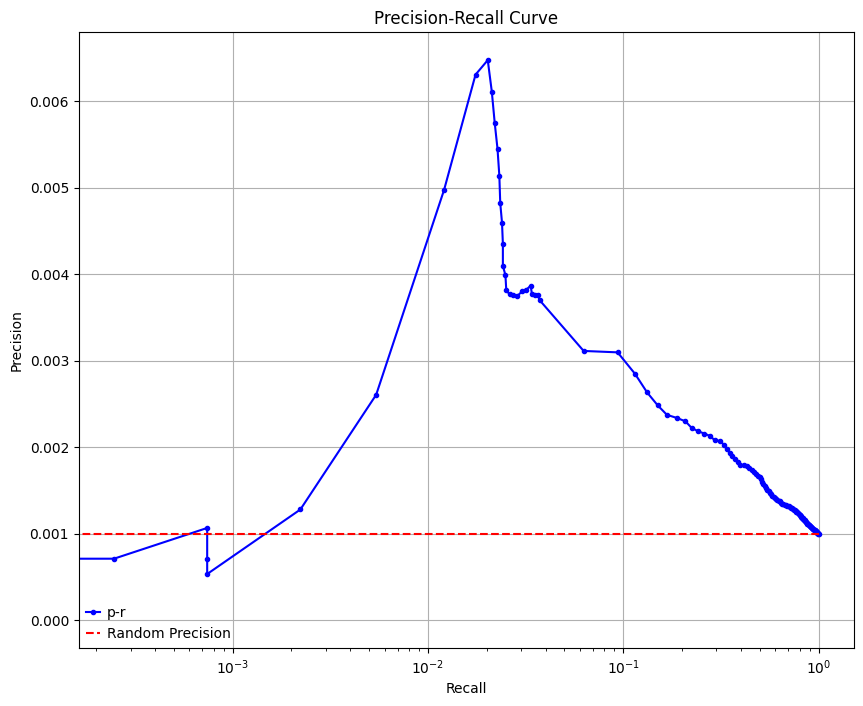

precision:  0.0008424353775397419 
recall:  1.0 
random precision: 0.0008427099653420691


 52%|█████▏    | 66/128 [00:00<00:00, 659.71it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 657.21it/s]


Average Precision (AP):  0.0008553333295223293
Area Under Precision-Recall Curve (AUPRC):  0.0008499064660402024
No true positives found. Returning EPR as 0.
EPR: 0.0


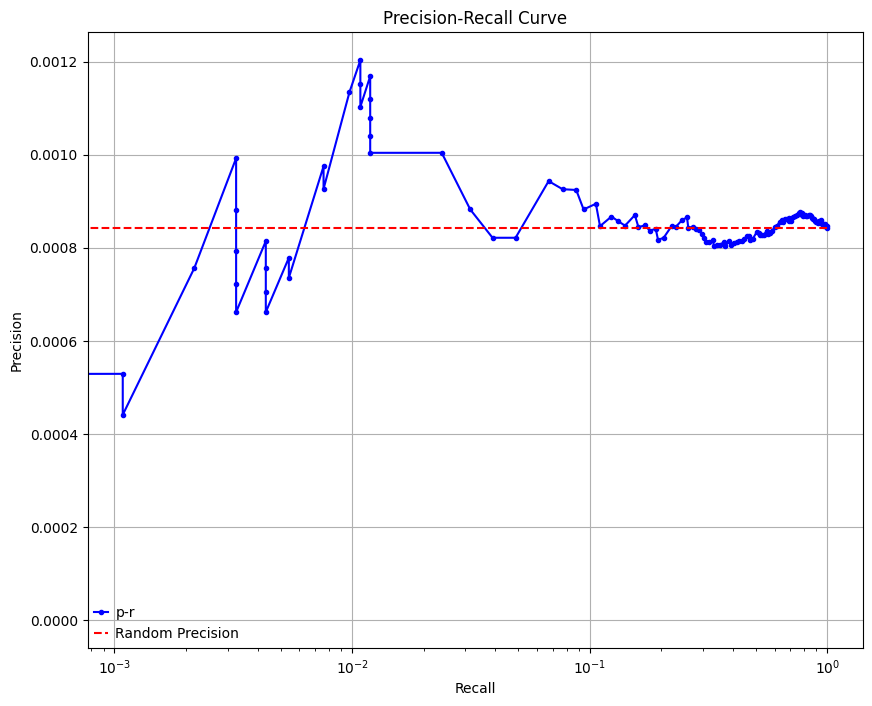

precision:  0.020393799799474872 
recall:  1.0 
random precision: 0.02041271798110704


 52%|█████▏    | 67/128 [00:00<00:00, 663.84it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 660.72it/s]


Average Precision (AP):  0.021725440698375686
Area Under Precision-Recall Curve (AUPRC):  0.021710048006931854
EPR: 0.7688131681474087


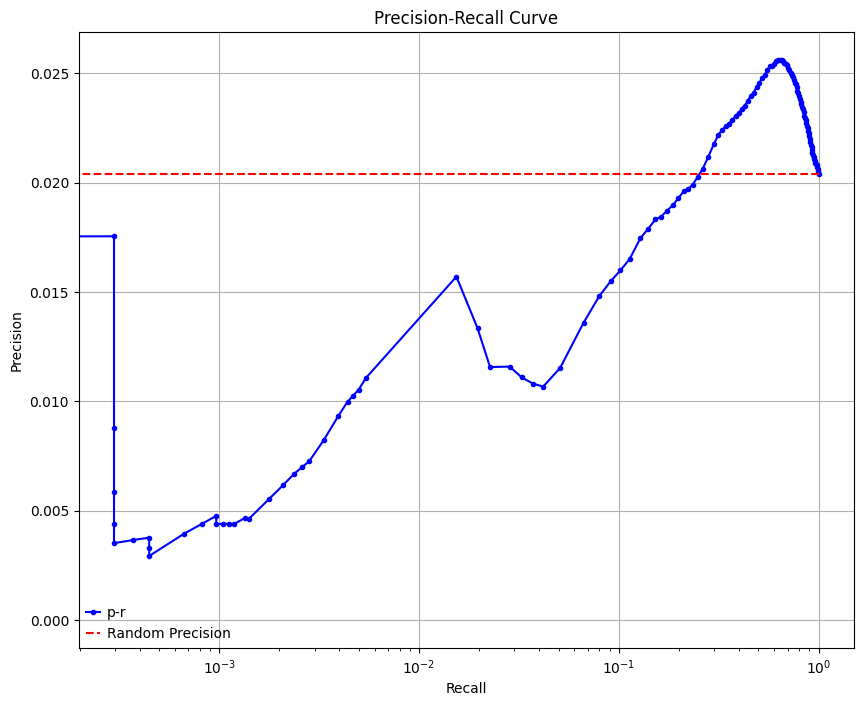

precision:  0.00210688024308096 
recall:  1.0 
random precision: 0.0021075669706699693


 94%|█████████▍| 120/128 [00:01<00:00, 73.62it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 73.48it/s]


Average Precision (AP):  0.0019790368813557987
Area Under Precision-Recall Curve (AUPRC):  0.001978167203000946
EPR: 0.5973195322480535


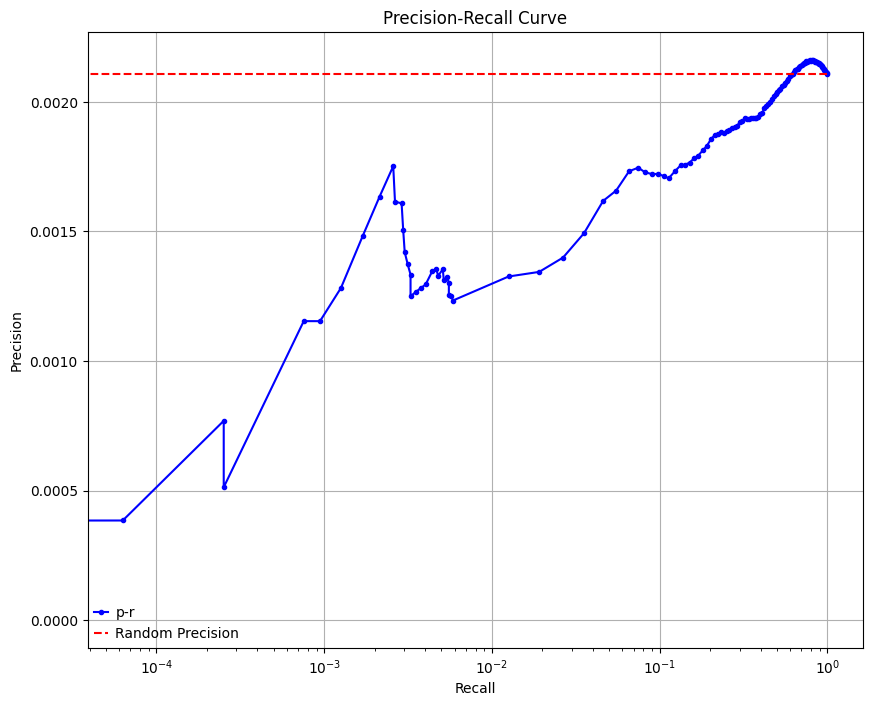

number of expressed genes in this cell type: 17234


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 26/26 [00:10<00:00,  2.42it/s]
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 8450649, sparsity: 1.0
loading GT,  collectri
intersection of 1104 genes
intersection pct: 0.3799036476256022
only tf:  False
using only tf:  0.3799036476256022
total true edges:  975.0
precision:  0.0007999566792690611 
recall:  1.0 
random precision: 0.000800681934644645


 95%|█████████▌| 122/128 [00:00<00:00, 605.97it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 602.98it/s]


Average Precision (AP):  0.0011842425909145283
Area Under Precision-Recall Curve (AUPRC):  0.0011801322637740527
No true positives found. Returning EPR as 0.
EPR: 0.0


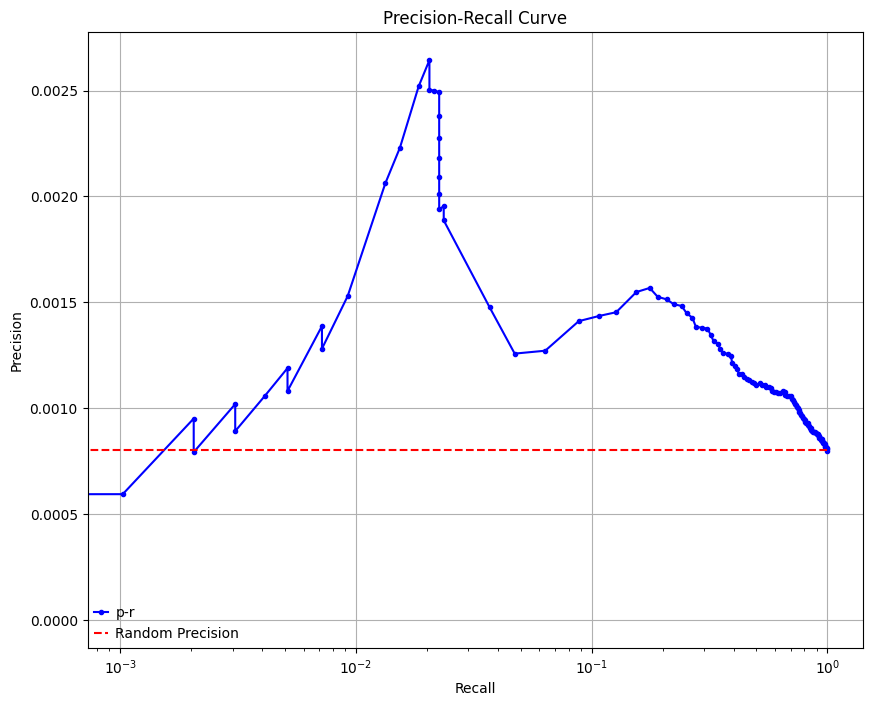

loading GT,  omnipath
intersection of 2072 genes
intersection pct: 0.7130075705437027
only tf:  False
using only tf:  0.7130075705437027
total true edges:  3794.0
precision:  0.0008837263904831473 
recall:  1.0 
random precision: 0.0008841531053023086


 88%|████████▊ | 112/128 [00:00<00:00, 151.07it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 150.71it/s]


Average Precision (AP):  0.001403251230396189
Area Under Precision-Recall Curve (AUPRC):  0.001401430221101886
EPR: 0.29810907492311617


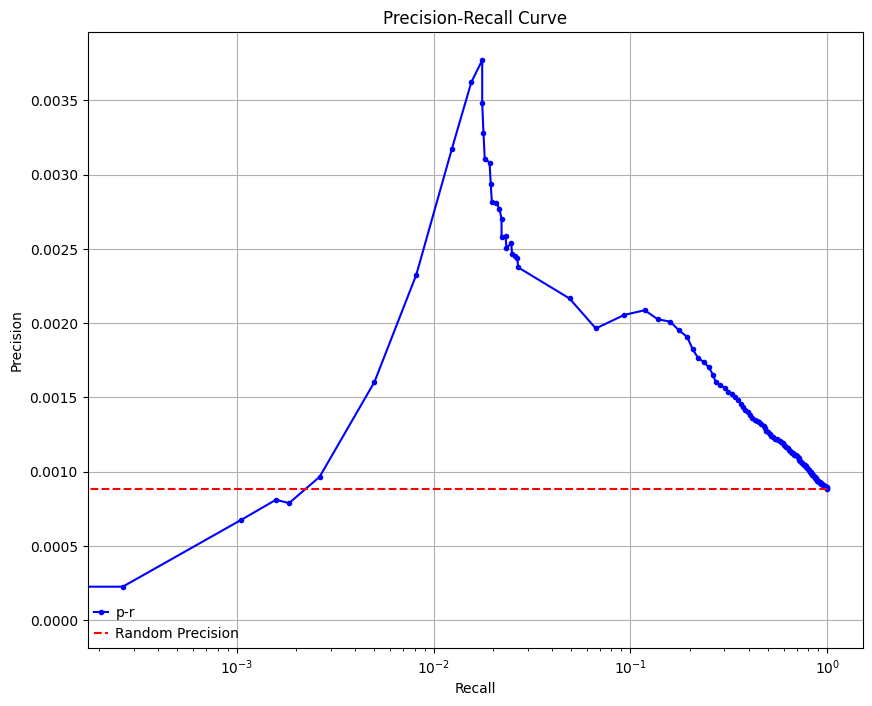

precision:  0.0009974558562653485 
recall:  1.0 
random precision: 0.0009977700155901566


 89%|████████▉ | 114/128 [00:00<00:00, 565.38it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 563.84it/s]


Average Precision (AP):  0.001050188297061808
Area Under Precision-Recall Curve (AUPRC):  0.0010460979359855132
EPR: 1.5858148233456175


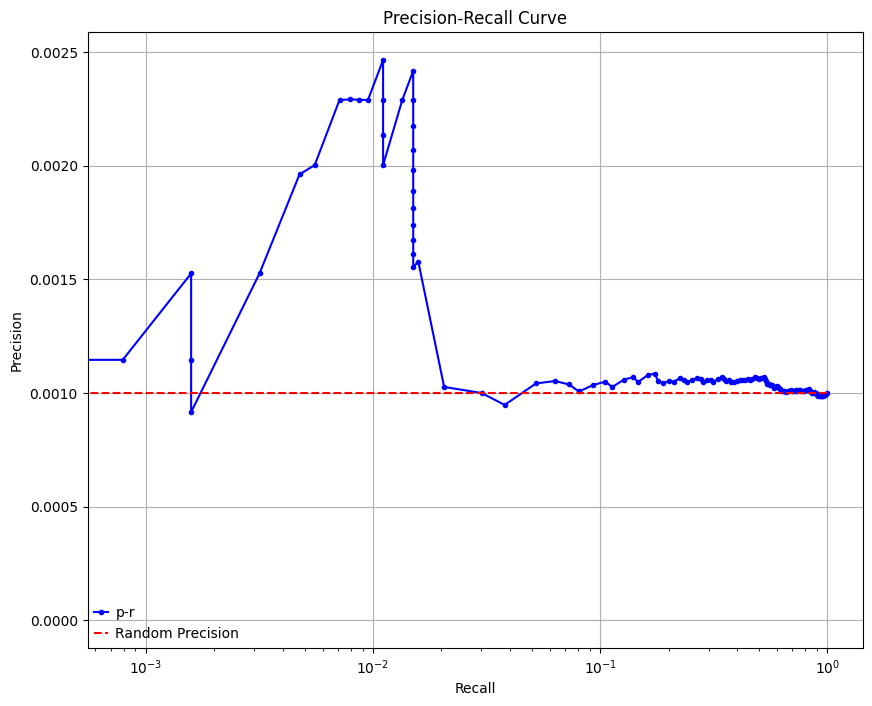

precision:  0.02412672286232065 
recall:  1.0 
random precision: 0.02414307996256629


 82%|████████▏ | 105/128 [00:00<00:00, 341.91it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 341.39it/s]


Average Precision (AP):  0.025623913632011476
Area Under Precision-Recall Curve (AUPRC):  0.02561487775620738
EPR: 0.26259282076753143


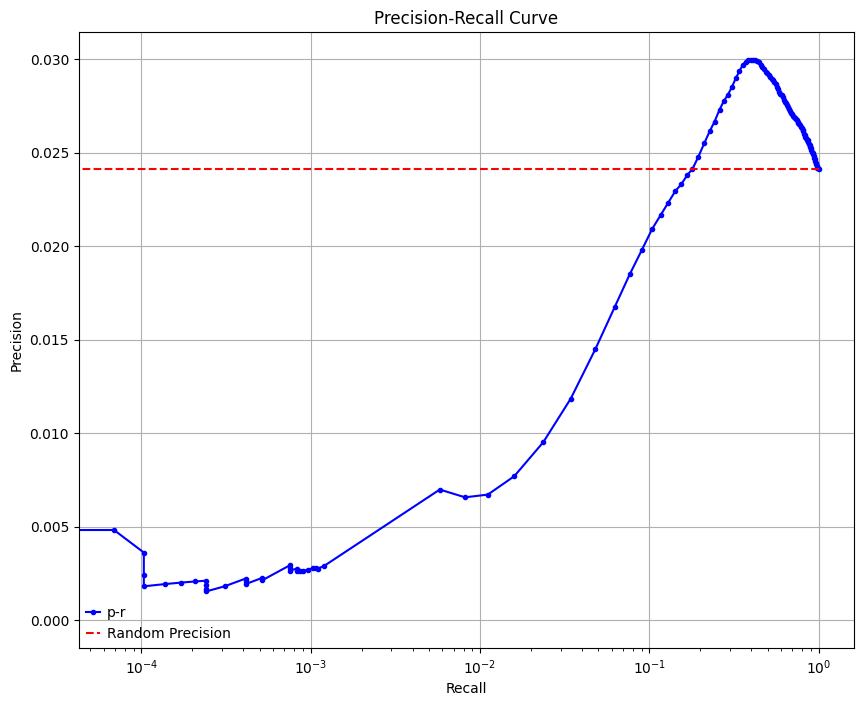

precision:  0.0023138570492112617 
recall:  1.0 
random precision: 0.002314585823085029


 98%|█████████▊| 126/128 [00:01<00:00, 67.65it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 67.80it/s]


Average Precision (AP):  0.0020712522976204365
Area Under Precision-Recall Curve (AUPRC):  0.0020705370150649292
EPR: 0.5963956054735742


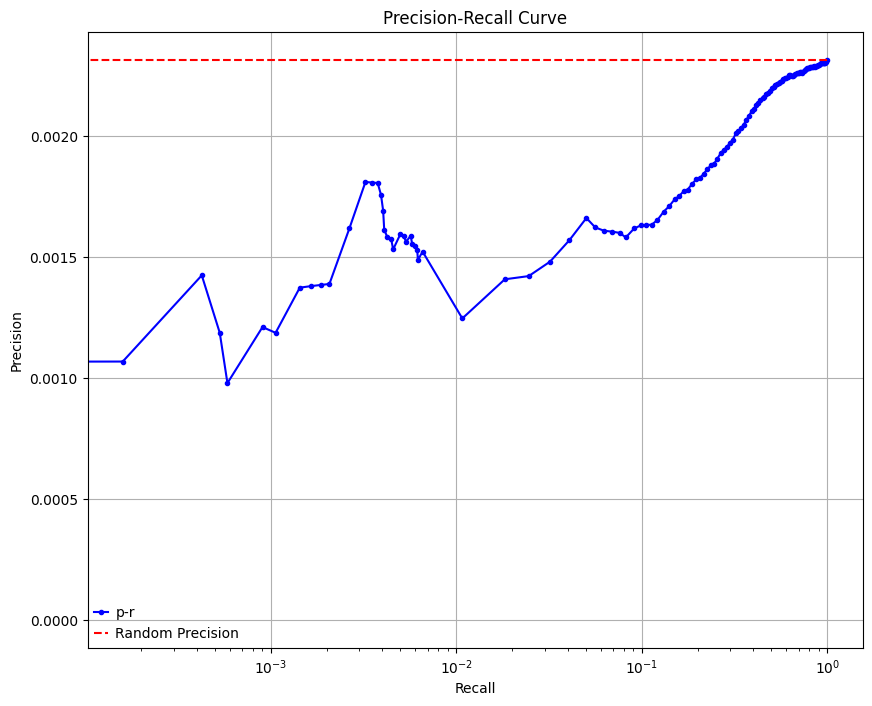

number of expressed genes in this cell type: 14155


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 8720209, sparsity: 1.0
loading GT,  collectri
intersection of 1082 genes
intersection pct: 0.36653116531165314
only tf:  False
using only tf:  0.36653116531165314
total true edges:  1415.0
precision:  0.0012086537903041195 
recall:  1.0 
random precision: 0.0012097718789167967


 98%|█████████▊| 126/128 [00:00<00:00, 623.54it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 619.08it/s]


Average Precision (AP):  0.0017748403969035044
Area Under Precision-Recall Curve (AUPRC):  0.0017712577176512622
EPR: 0.584171109640525


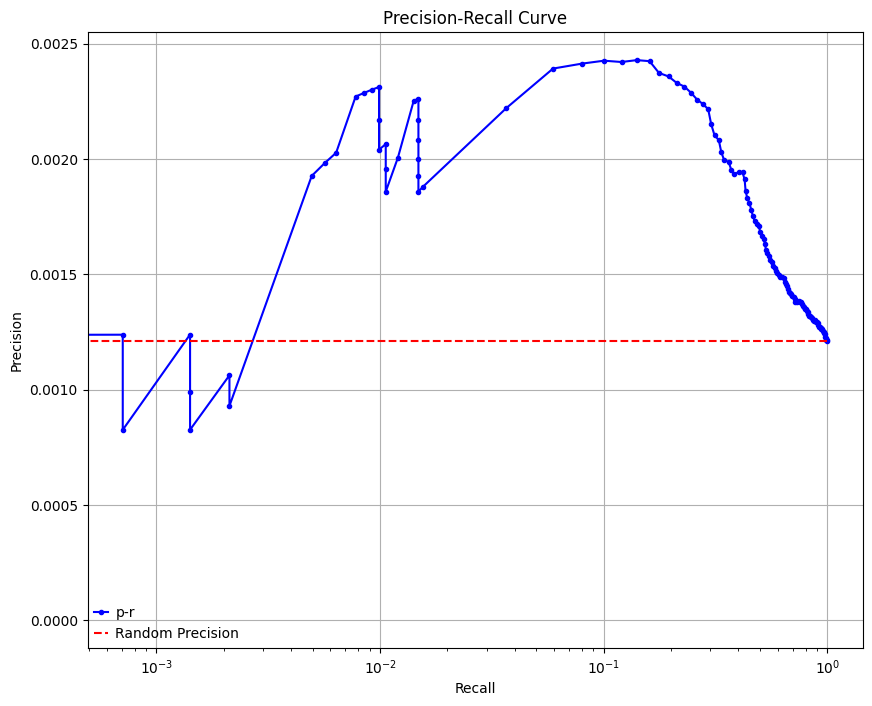

loading GT,  omnipath
intersection of 2118 genes
intersection pct: 0.717479674796748
only tf:  False
using only tf:  0.717479674796748
total true edges:  5265.0
precision:  0.0011736712436501377 
recall:  1.0 
random precision: 0.0011742256466939025


 94%|█████████▍| 120/128 [00:00<00:00, 143.02it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 143.22it/s]


Average Precision (AP):  0.0017282601250631652
Area Under Precision-Recall Curve (AUPRC):  0.001724479503862171
EPR: 1.7792736530818203


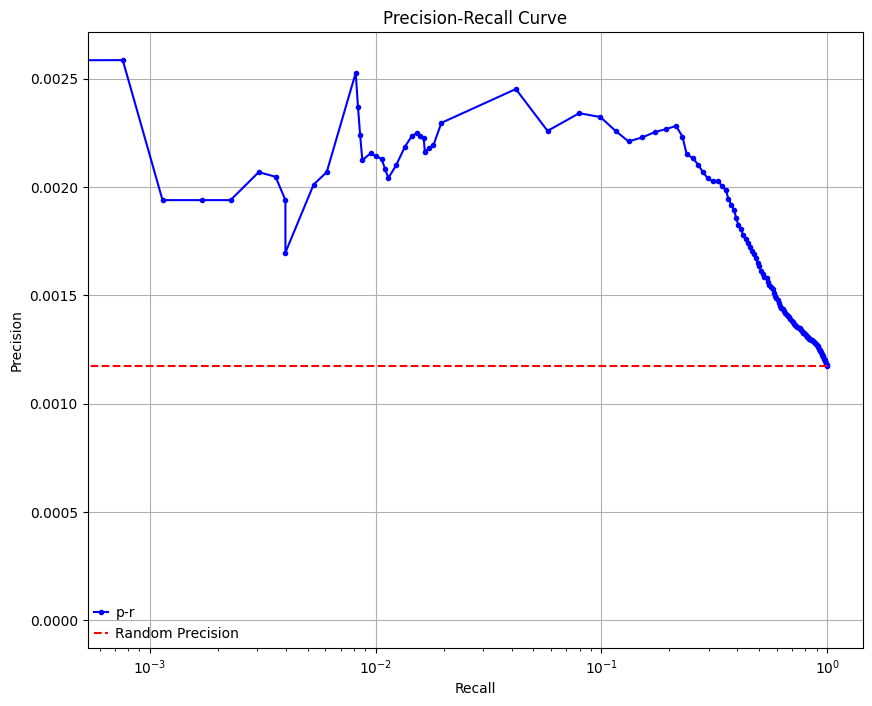

precision:  0.001168891730052407 
recall:  1.0 
random precision: 0.0011692546272054813


 86%|████████▌ | 110/128 [00:00<00:00, 547.93it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 544.19it/s]


Average Precision (AP):  0.0010632132222821297
Area Under Precision-Recall Curve (AUPRC):  0.0010607252973667356
No true positives found. Returning EPR as 0.
EPR: 0.0


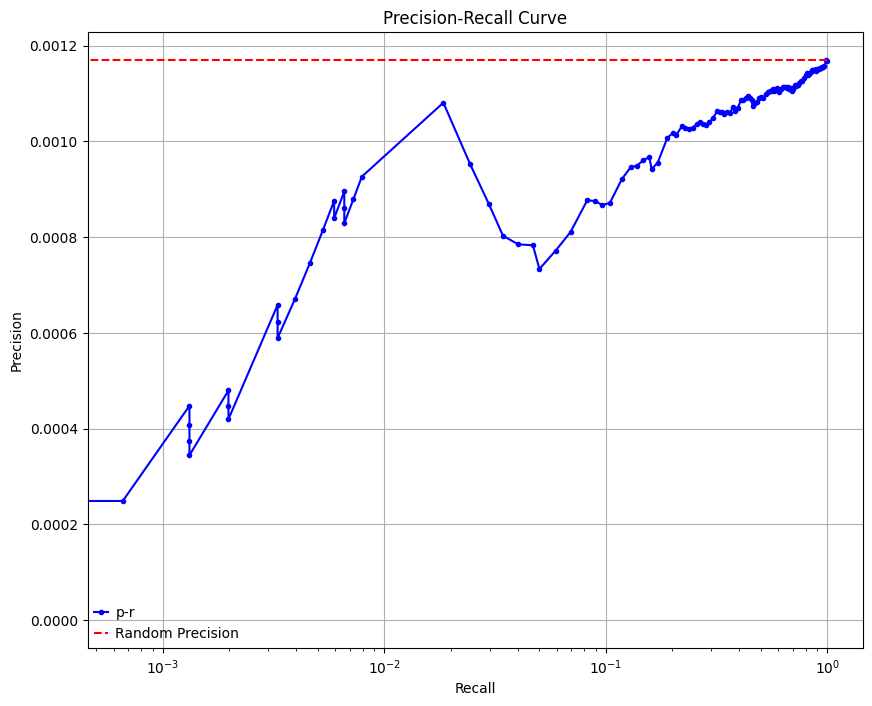

precision:  0.02247047030007282 
recall:  1.0 
random precision: 0.02248255769668394


 95%|█████████▍| 121/128 [00:01<00:00, 105.47it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 104.91it/s]


Average Precision (AP):  0.021654449556776506
Area Under Precision-Recall Curve (AUPRC):  0.021644542498923815
EPR: 0.6879486953871813


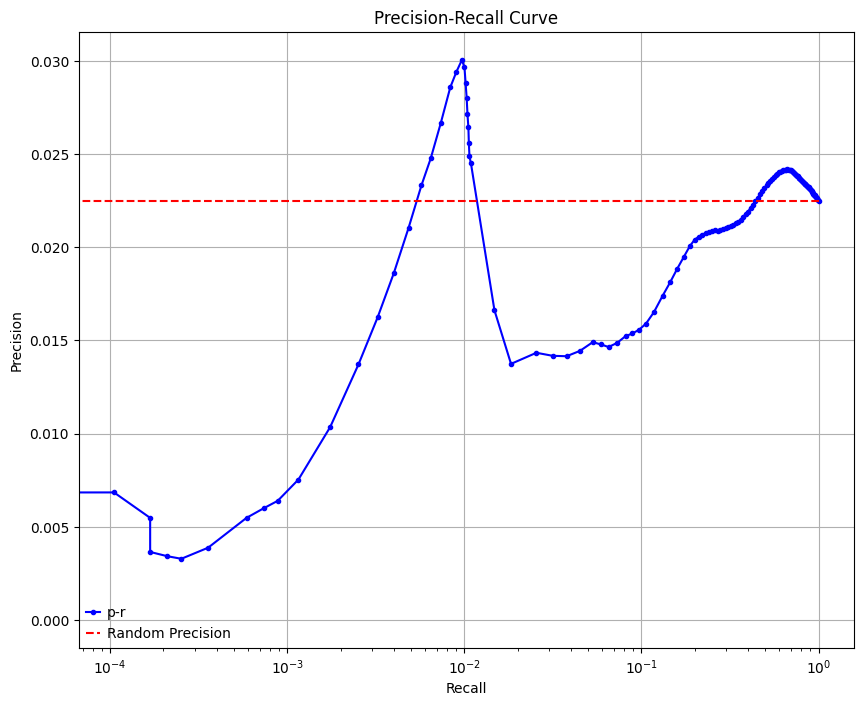

precision:  0.002699798114939706 
recall:  1.0 
random precision: 0.002700636301252944


 98%|█████████▊| 126/128 [00:02<00:00, 55.70it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 55.93it/s]


Average Precision (AP):  0.002394570862060176
Area Under Precision-Recall Curve (AUPRC):  0.0023940429988216047
EPR: 0.1129108619834133


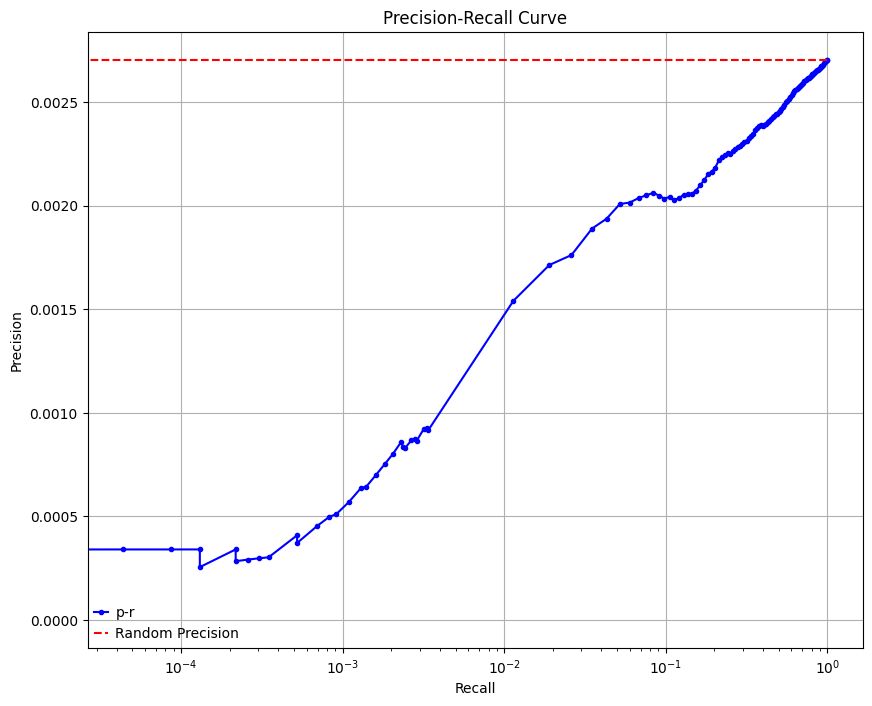

number of expressed genes in this cell type: 12954


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 8714304, sparsity: 1.0
loading GT,  collectri
intersection of 1087 genes
intersection pct: 0.36834971196204674
only tf:  False
using only tf:  0.36834971196204674
total true edges:  1274.0
precision:  0.0010782273400876292 
recall:  1.0 
random precision: 0.001079220182942222


 97%|█████████▋| 124/128 [00:00<00:00, 614.22it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 611.78it/s]


Average Precision (AP):  0.0016126354082940145
Area Under Precision-Recall Curve (AUPRC):  0.0016053846642866815
EPR: 0.7273115984710512


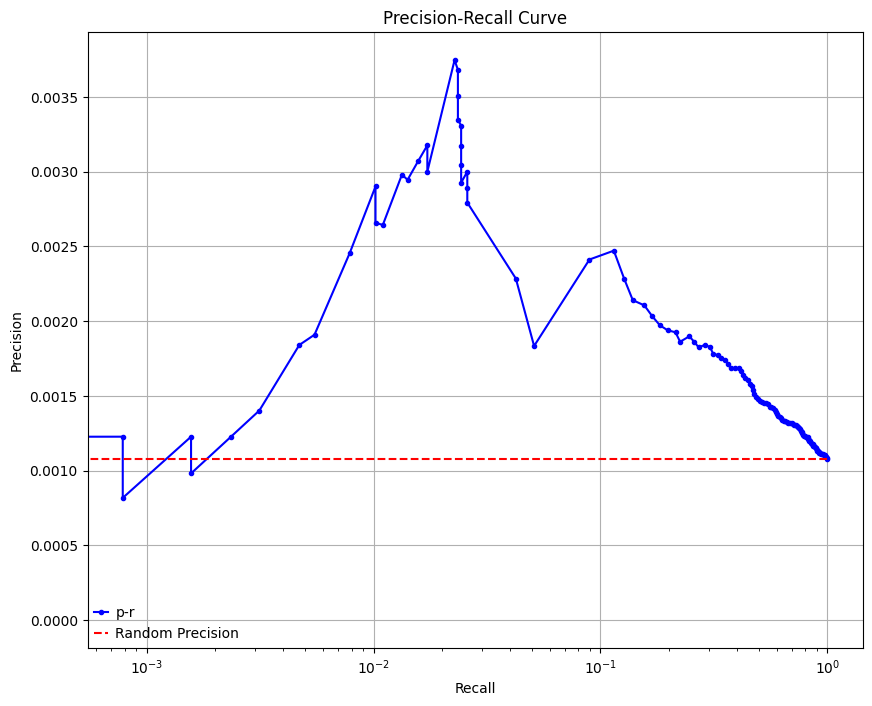

loading GT,  omnipath
intersection of 2068 genes
intersection pct: 0.7007793968146391
only tf:  False
using only tf:  0.7007793968146391
total true edges:  5149.0
precision:  0.0012039870701749792 
recall:  1.0 
random precision: 0.0012045695506153154


 94%|█████████▍| 120/128 [00:00<00:00, 140.94it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 140.40it/s]


Average Precision (AP):  0.0017635801276010576
Area Under Precision-Recall Curve (AUPRC):  0.001764220680357672
EPR: 3.869514417154577


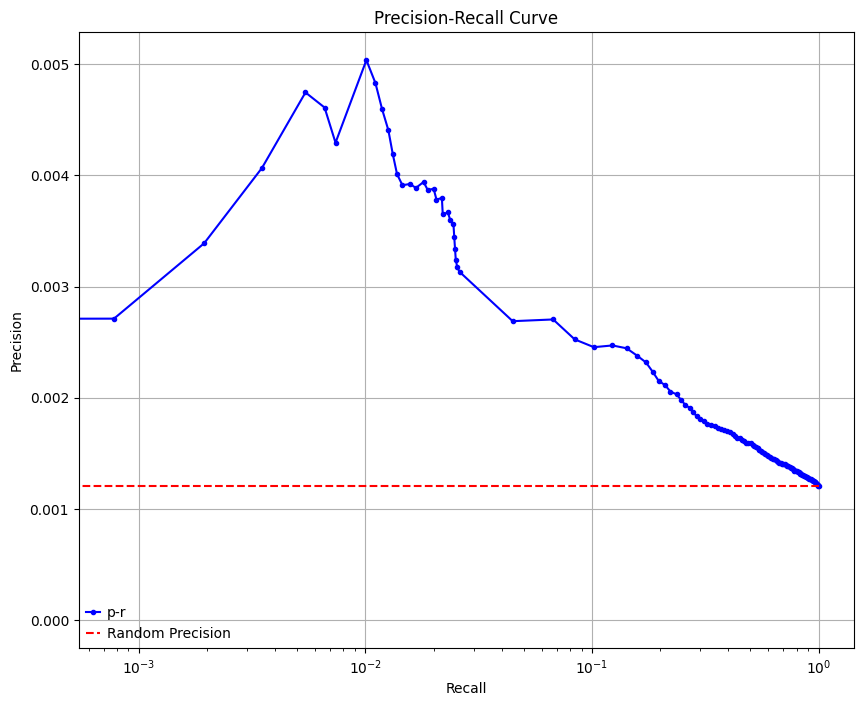

precision:  0.0011463225748940035 
recall:  1.0 
random precision: 0.0011466771442026622


 78%|███████▊  | 100/128 [00:00<00:00, 492.29it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 491.20it/s]


Average Precision (AP):  0.0010958525360977422
Area Under Precision-Recall Curve (AUPRC):  0.0010863329000135916
EPR: 0.5298208108614868


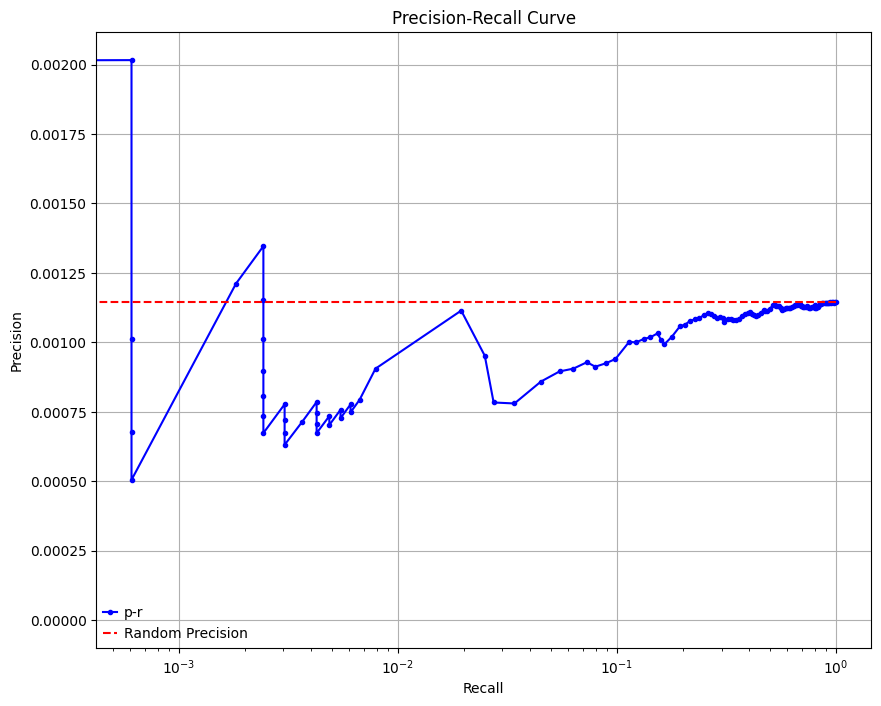

precision:  0.02060871518418688 
recall:  1.0 
random precision: 0.020618404283944375


 92%|█████████▏| 118/128 [00:00<00:00, 128.59it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 128.50it/s]


Average Precision (AP):  0.019282118871956546
Area Under Precision-Recall Curve (AUPRC):  0.019278590744106042
EPR: 0.4683336881399644


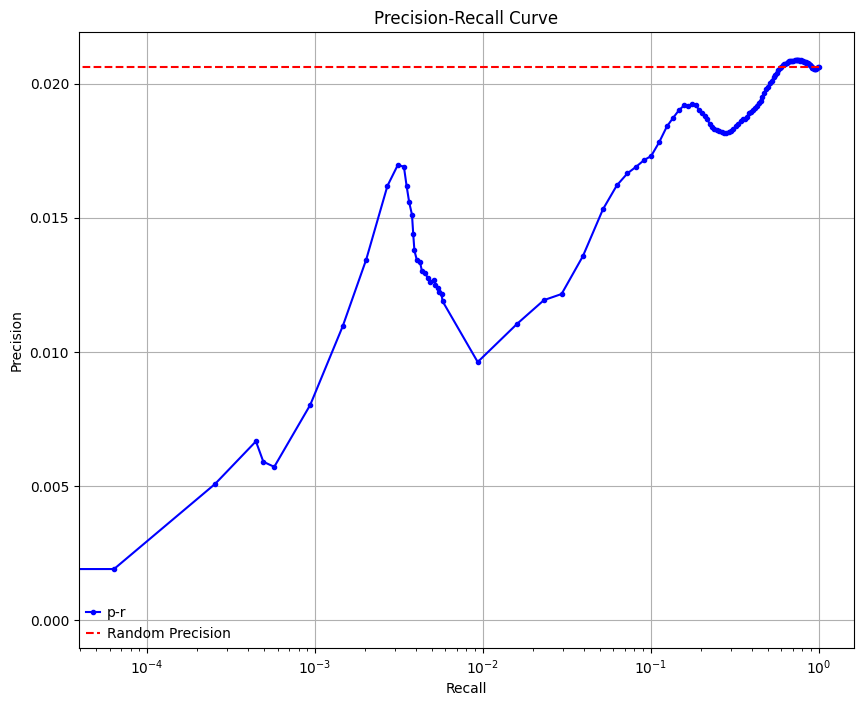

precision:  0.0029823418491769266 
recall:  1.0 
random precision: 0.0029832643180445965


 98%|█████████▊| 126/128 [00:02<00:00, 57.89it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 57.83it/s]


Average Precision (AP):  0.0025320969368221253
Area Under Precision-Recall Curve (AUPRC):  0.00253112377738532
EPR: 0.15050660114814843


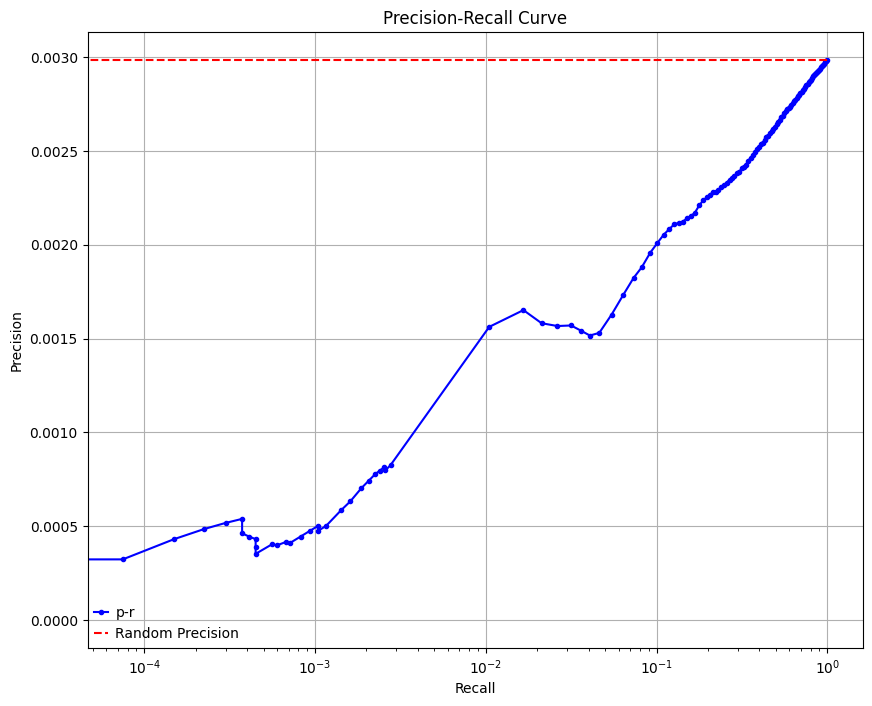

number of expressed genes in this cell type: 13249


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 8684809, sparsity: 1.0
loading GT,  collectri
intersection of 1251 genes
intersection pct: 0.42464358452138495
only tf:  False
using only tf:  0.42464358452138495
total true edges:  1622.0
precision:  0.001036421062989736 
recall:  1.0 
random precision: 0.001037250199840128


 73%|███████▎  | 94/128 [00:00<00:00, 460.77it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 458.67it/s]


Average Precision (AP):  0.0017021448560088782
Area Under Precision-Recall Curve (AUPRC):  0.001686031314935142
EPR: 1.7831458931674675


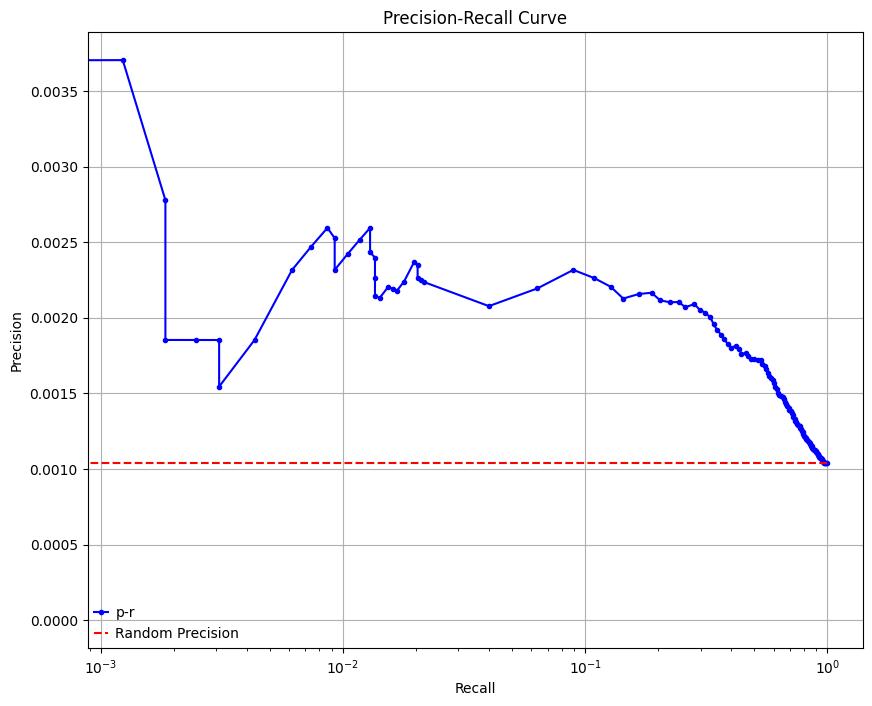

loading GT,  omnipath
intersection of 2159 genes
intersection pct: 0.7328581126951799
only tf:  False
using only tf:  0.7328581126951799
total true edges:  5226.0
precision:  0.0011211510312293981 
recall:  1.0 
random precision: 0.0011216705636813117


 98%|█████████▊| 126/128 [00:00<00:00, 135.89it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 135.98it/s]


Average Precision (AP):  0.0018434100991425605
Area Under Precision-Recall Curve (AUPRC):  0.0018321503560471228
EPR: 2.729513549740772


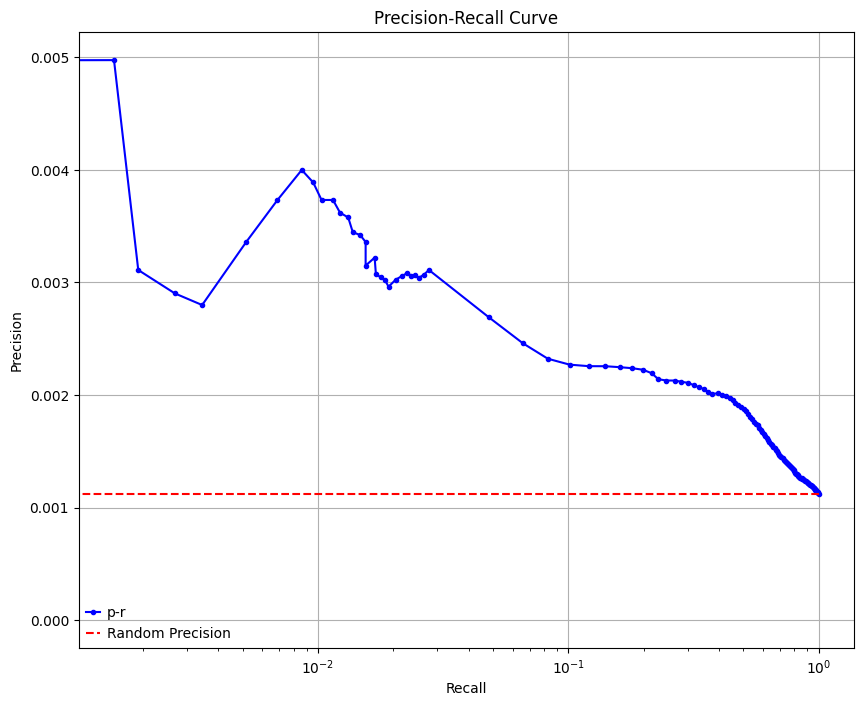

precision:  0.0010523466108129124 
recall:  1.0 
random precision: 0.0010526744446480566


 77%|███████▋  | 98/128 [00:00<00:00, 487.19it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 485.08it/s]


Average Precision (AP):  0.0009998185966248495
Area Under Precision-Recall Curve (AUPRC):  0.000986851620672997
EPR: 1.2249662350489543


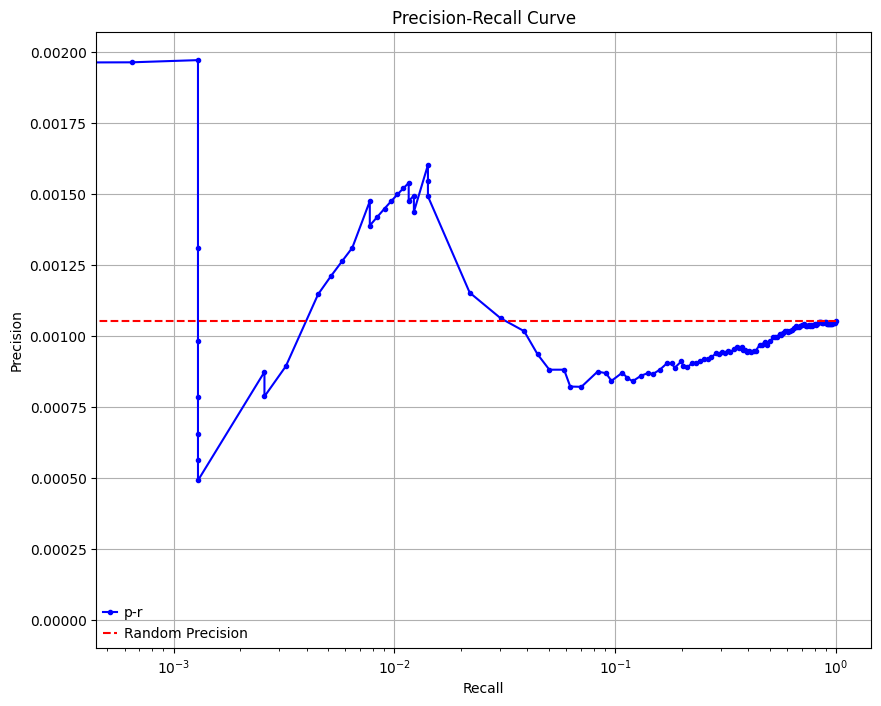

precision:  0.02047742546942644 
recall:  1.0 
random precision: 0.020488536389377296


 94%|█████████▍| 120/128 [00:00<00:00, 197.79it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 196.99it/s]


Average Precision (AP):  0.01970139335523981
Area Under Precision-Recall Curve (AUPRC):  0.019696001529184035
EPR: 0.5012661455937587


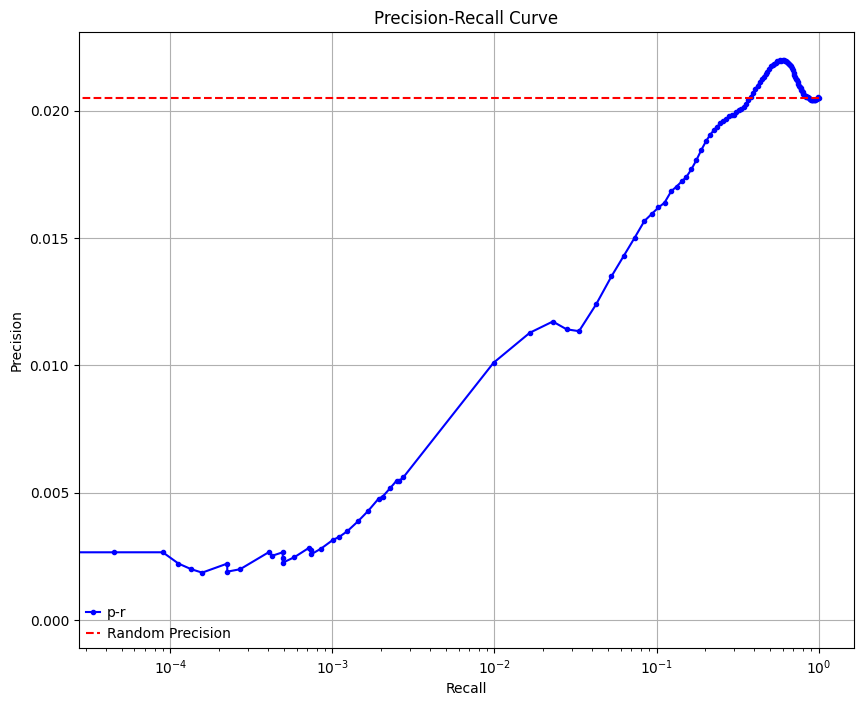

precision:  0.00256320685989992 
recall:  1.0 
random precision: 0.0025640053667098576


 98%|█████████▊| 126/128 [00:02<00:00, 60.45it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 60.25it/s]


Average Precision (AP):  0.0022631277435659586
Area Under Precision-Recall Curve (AUPRC):  0.002262506548224857
EPR: 0.3319869585320239


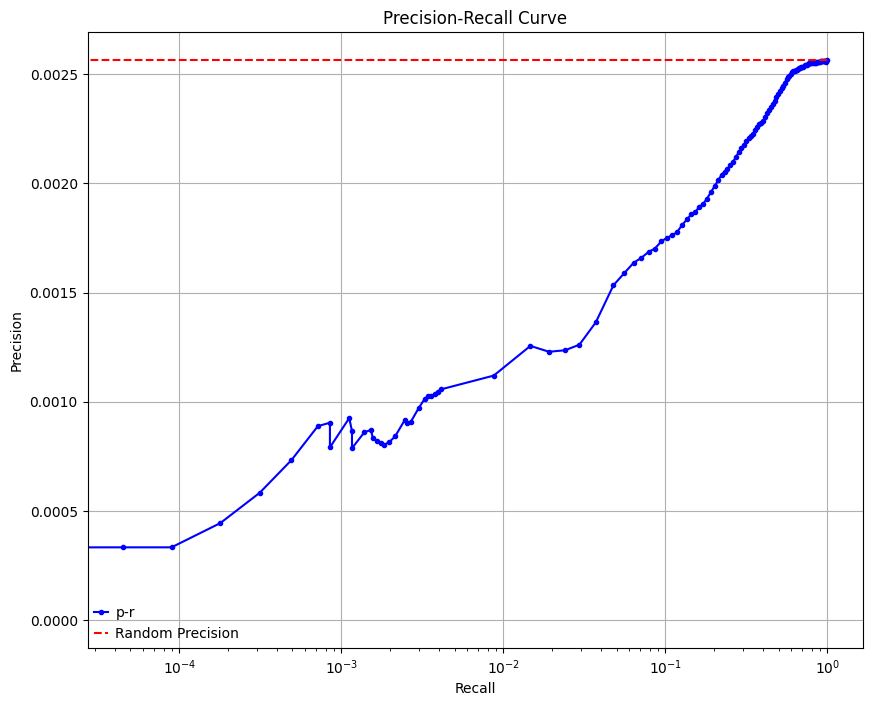

number of expressed genes in this cell type: 13521


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 8643600, sparsity: 1.0
loading GT,  collectri
intersection of 1080 genes
intersection pct: 0.36747192922762845
only tf:  False
using only tf:  0.36747192922762845
total true edges:  715.0
precision:  0.000612997256515775 
recall:  1.0 
random precision: 0.0006135653726015172


 50%|█████     | 64/128 [00:00<00:00, 634.81it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 629.05it/s]


Average Precision (AP):  0.0008527235162457846
Area Under Precision-Recall Curve (AUPRC):  0.0008426809440857284
EPR: 2.2794659885568977


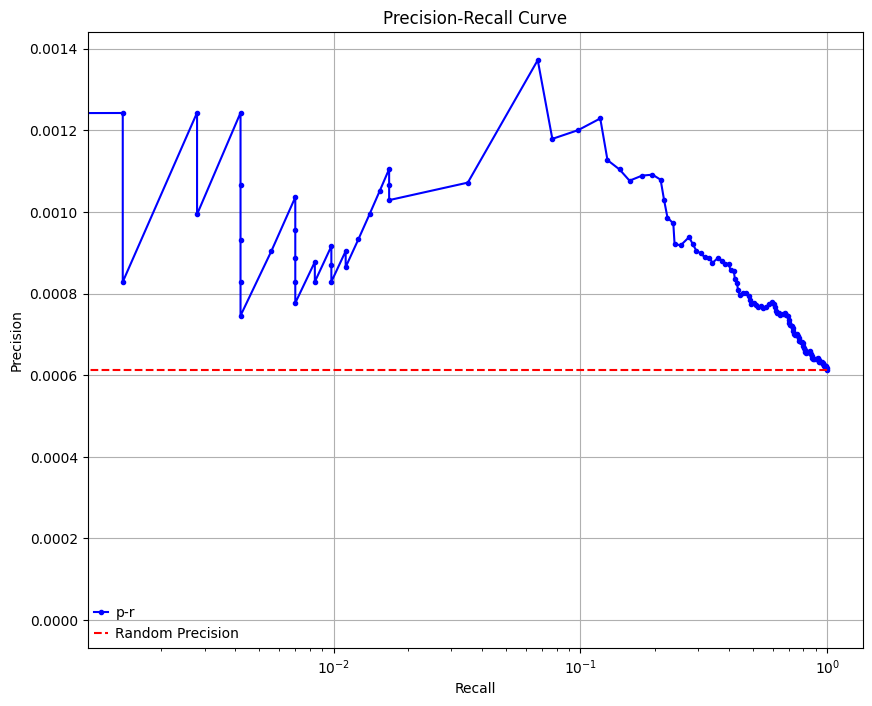

loading GT,  omnipath
intersection of 2096 genes
intersection pct: 0.7131677441306566
only tf:  False
using only tf:  0.7131677441306566
total true edges:  3650.0
precision:  0.000830826437853272 
recall:  1.0 
random precision: 0.0008312230137185957


 94%|█████████▍| 120/128 [00:00<00:00, 145.99it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 145.78it/s]


Average Precision (AP):  0.001082207873430046
Area Under Precision-Recall Curve (AUPRC):  0.0010760844436603764
EPR: 2.9664162131732033


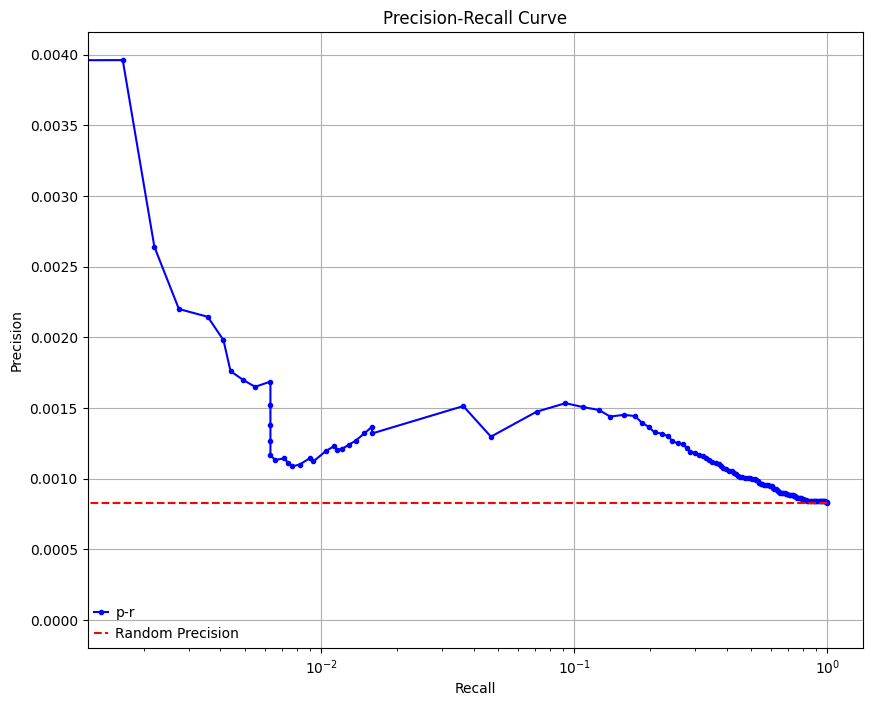

precision:  0.0011074245786732878 
recall:  1.0 
random precision: 0.0011077702168064568


 83%|████████▎ | 106/128 [00:00<00:00, 521.16it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 518.49it/s]


Average Precision (AP):  0.0010425299432658807
Area Under Precision-Recall Curve (AUPRC):  0.0010395947808057697
No true positives found. Returning EPR as 0.
EPR: 0.0


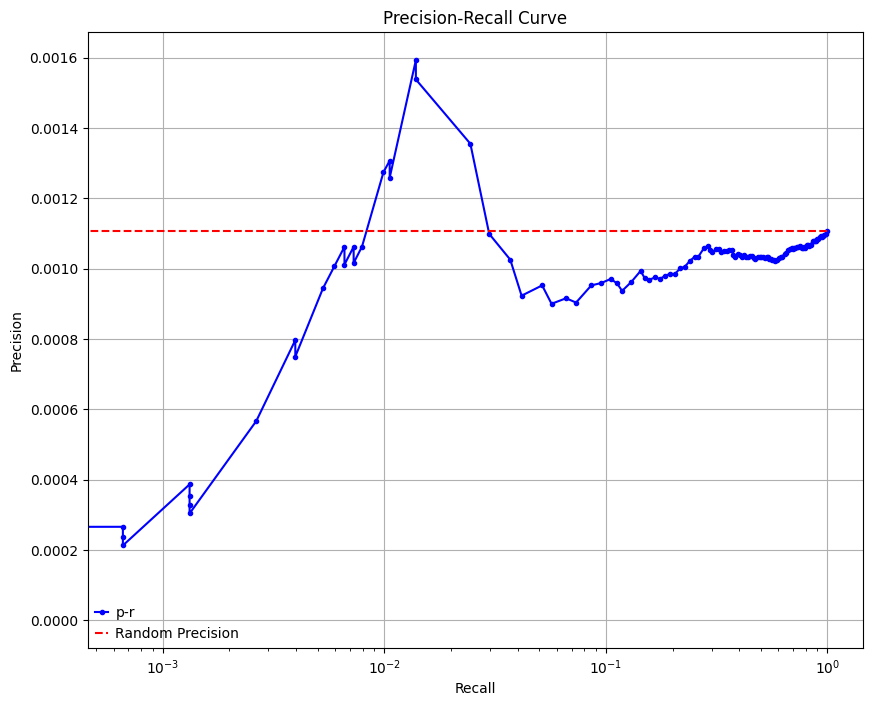

precision:  0.02122002269575085 
recall:  1.0 
random precision: 0.021232155355954255


 86%|████████▌ | 110/128 [00:00<00:00, 213.69it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 213.61it/s]


Average Precision (AP):  0.02201393489493468
Area Under Precision-Recall Curve (AUPRC):  0.022024110077434995
EPR: 1.8145758598852293


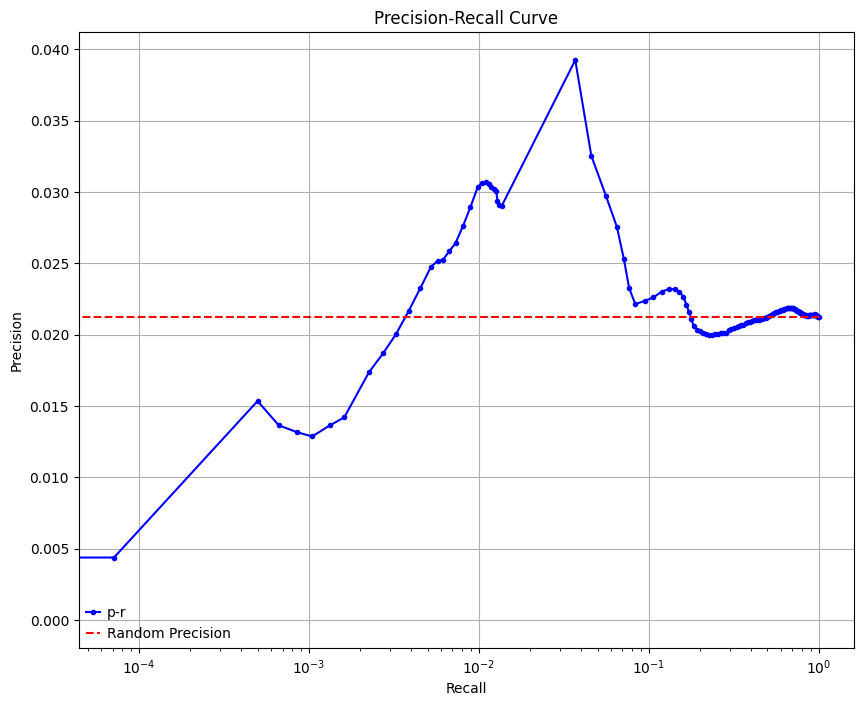

precision:  0.0024417515162144946 
recall:  1.0 
random precision: 0.0024425136109448987


 98%|█████████▊| 126/128 [00:02<00:00, 62.49it/s]/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 62.44it/s]


Average Precision (AP):  0.0021738706251222084
Area Under Precision-Recall Curve (AUPRC):  0.0021729721527092155
EPR: 0.735208326443446


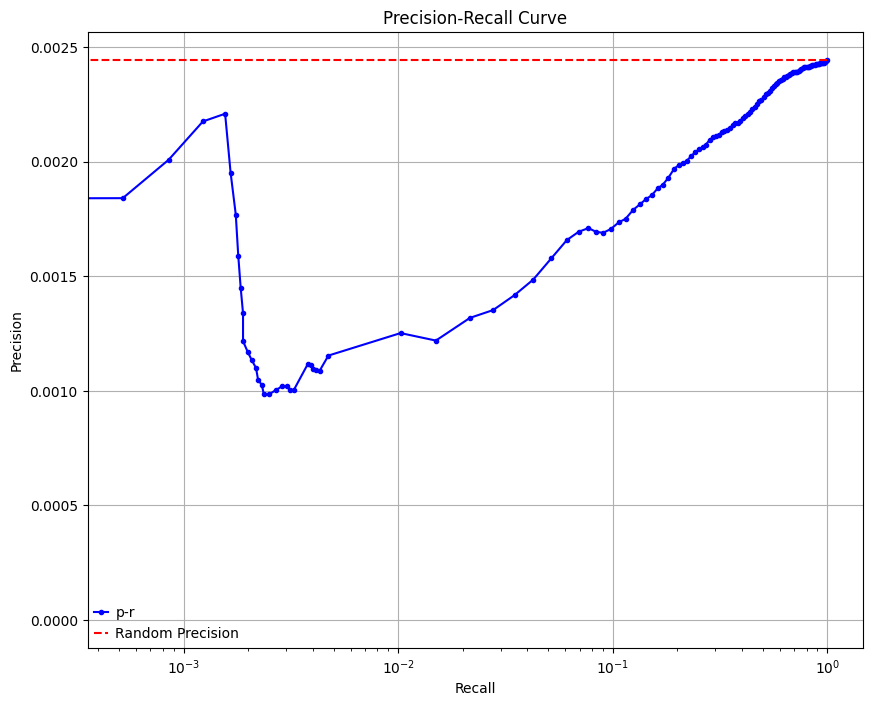

In [83]:
metrics = {}
shapes = []
for celltype in adata.obs.cell_type.value_counts().keys().tolist():
    grn_inferer = GNInfer(
        how="most var within",
        preprocess="softmax",
        head_agg="mean",
        filtration="none",
        num_genes=3000,
        max_cells=1024,
        num_workers=8,
        batch_size=16,
    )
    grn = grn_inferer(model, adata[adata.obs.cell_type.isin([celltype])])
    grn.var.index = make_index_unique(grn.var["symbol"].astype(str))
    metrics[celltype + "_collectri"] = BenGRN(grn).compare_to(to="collectri")
    metrics[celltype + "_omnipath"] = BenGRN(grn).compare_to(to="omnipath")
    metrics[celltype + "_cellmap"] = BenGRN(grn).compare_to(gt_cm)
    metrics[celltype + "_gwps"] = BenGRN(grn).compare_to(gwps)
    metrics[celltype + "_interact"] = BenGRN(grn).compare_to(gt_inter)
# grn.varp["all"] = grn.varp["GRN"]
# grn.varp["GRN"] = grn.varp["GRN"][:, :, :].mean(-1)
# metrics[celltype + "_scprint_mean"] = BenGRN(grn).scprint_benchmark()

In [84]:
metrics

{'myeloid cell_collectri': {'precision': np.float64(0.0012939288856684437),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0012950935381307914),
  'auprc': np.float64(0.0023515517610108233),
  'ap': np.float64(0.0023844819820559074),
  'epr': np.float64(2.89554375),
  'odd_ratio': np.float64(2.90984069810094)},
 'myeloid cell_omnipath': {'precision': np.float64(0.001172037663315405),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011725997916910958),
  'auprc': np.float64(0.0022395127762862644),
  'ap': np.float64(0.0022532868600549628),
  'epr': np.float64(5.016505190311419),
  'odd_ratio': np.float64(5.064178425125171)},
 'myeloid cell_cellmap': {'precision': np.float64(0.0010859056694979628),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0010862432217732187),
  'auprc': np.float64(0.0009862116680630318),
  'ap': np.float64(0.0009905605182477688),
  'epr': np.float64(1.4635995763836407),
  'odd_ratio': np.float64(1.4650771836585663)},
 '

In [1]:
res = {'myeloid cell_collectri': {'precision': np.float64(0.0012939288856684437),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0012950935381307914),
  'auprc': np.float64(0.0023515517610108233),
  'ap': np.float64(0.0023844819820559074),
  'epr': np.float64(2.89554375),
  'odd_ratio': np.float64(2.90984069810094)},
 'myeloid cell_omnipath': {'precision': np.float64(0.001172037663315405),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011725997916910958),
  'auprc': np.float64(0.0022395127762862644),
  'ap': np.float64(0.0022532868600549628),
  'epr': np.float64(5.016505190311419),
  'odd_ratio': np.float64(5.064178425125171)},
 'myeloid cell_cellmap': {'precision': np.float64(0.0010859056694979628),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0010862432217732187),
  'auprc': np.float64(0.0009862116680630318),
  'ap': np.float64(0.0009905605182477688),
  'epr': np.float64(1.4635995763836407),
  'odd_ratio': np.float64(1.4650771836585663)},
 'myeloid cell_gwps': {'precision': np.float64(0.01924866716228692),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.019262338090669226),
  'auprc': np.float64(0.019575465063865025),
  'ap': np.float64(0.01957960627987488),
  'epr': np.float64(0.7449586254559185),
  'odd_ratio': np.float64(0.7374785012899354)},
 'myeloid cell_interact': {'precision': np.float64(0.002134992600856161),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0021356562603528522),
  'auprc': np.float64(0.0019357570056030208),
  'ap': np.float64(0.0019365973966491191),
  'epr': np.float64(0.263648731079052),
  'odd_ratio': np.float64(0.2628188057925015)},
 'neoplastic cell_collectri': {'precision': np.float64(0.0012484305900271758),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0012494832296477722),
  'auprc': np.float64(0.0018626793005657944),
  'ap': np.float64(0.001871824760264888),
  'epr': np.float64(0.9099839338401289),
  'odd_ratio': np.float64(0.9097788859198542)},
 'neoplastic cell_omnipath': {'precision': np.float64(0.0009930398980492108),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0009935317454479475),
  'auprc': np.float64(0.0018297395974075908),
  'ap': np.float64(0.0018293539972560986),
  'epr': np.float64(0.7451952358724537),
  'odd_ratio': np.float64(0.744817514223301)},
 'neoplastic cell_cellmap': {'precision': np.float64(0.0008424353775397419),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0008427099653420691),
  'auprc': np.float64(0.0008499064660402024),
  'ap': np.float64(0.0008553333295223293),
  'epr': np.float64(0.0),
  'odd_ratio': np.float64(0.0)},
 'neoplastic cell_gwps': {'precision': np.float64(0.020393799799474872),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.02041271798110704),
  'auprc': np.float64(0.021710048006931854),
  'ap': np.float64(0.021725440698375686),
  'epr': np.float64(0.7688131681474087),
  'odd_ratio': np.float64(0.7613824149807253)},
 'neoplastic cell_interact': {'precision': np.float64(0.00210688024308096),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0021075669706699693),
  'auprc': np.float64(0.001978167203000946),
  'ap': np.float64(0.0019790368813557987),
  'epr': np.float64(0.5973195322480535),
  'odd_ratio': np.float64(0.5963037529510695)},
 'oligodendrocyte precursor cell_collectri': {'precision': np.float64(0.0007999566792690611),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.000800681934644645),
  'auprc': np.float64(0.0011801322637740527),
  'ap': np.float64(0.0011842425909145283),
  'epr': np.float64(0.0),
  'odd_ratio': np.float64(0.0)},
 'oligodendrocyte precursor cell_omnipath': {'precision': np.float64(0.0008837263904831473),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0008841531053023086),
  'auprc': np.float64(0.001401430221101886),
  'ap': np.float64(0.001403251230396189),
  'epr': np.float64(0.29810907492311617),
  'odd_ratio': np.float64(0.29773892810023933)},
 'oligodendrocyte precursor cell_cellmap': {'precision': np.float64(0.0009974558562653485),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0009977700155901566),
  'auprc': np.float64(0.0010460979359855132),
  'ap': np.float64(0.001050188297061808),
  'epr': np.float64(1.5858148233456175),
  'odd_ratio': np.float64(1.5876730769713758)},
 'oligodendrocyte precursor cell_gwps': {'precision': np.float64(0.02412672286232065),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.02414307996256629),
  'auprc': np.float64(0.02561487775620738),
  'ap': np.float64(0.025623913632011476),
  'epr': np.float64(0.26259282076753143),
  'odd_ratio': np.float64(0.2531531199188836)},
 'oligodendrocyte precursor cell_interact': {'precision': np.float64(0.0023138570492112617),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.002314585823085029),
  'auprc': np.float64(0.0020705370150649292),
  'ap': np.float64(0.0020712522976204365),
  'epr': np.float64(0.5963956054735742),
  'odd_ratio': np.float64(0.5952790158539915)},
 'astrocyte_collectri': {'precision': np.float64(0.0012086537903041195),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0012097718789167967),
  'auprc': np.float64(0.0017712577176512622),
  'ap': np.float64(0.0017748403969035044),
  'epr': np.float64(0.584171109640525),
  'odd_ratio': np.float64(0.5835827419880804)},
 'astrocyte_omnipath': {'precision': np.float64(0.0011736712436501377),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011742256466939025),
  'auprc': np.float64(0.001724479503862171),
  'ap': np.float64(0.0017282601250631652),
  'epr': np.float64(1.7792736530818203),
  'odd_ratio': np.float64(1.7825401104659833)},
 'astrocyte_cellmap': {'precision': np.float64(0.001168891730052407),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011692546272054813),
  'auprc': np.float64(0.0010607252973667356),
  'ap': np.float64(0.0010632132222821297),
  'epr': np.float64(0.0),
  'odd_ratio': np.float64(0.0)},
 'astrocyte_gwps': {'precision': np.float64(0.02247047030007282),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.02248255769668394),
  'auprc': np.float64(0.021644542498923815),
  'ap': np.float64(0.021654449556776506),
  'epr': np.float64(0.6879486953871813),
  'odd_ratio': np.float64(0.6780671370604341)},
 'astrocyte_interact': {'precision': np.float64(0.002699798114939706),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.002700636301252944),
  'auprc': np.float64(0.0023940429988216047),
  'ap': np.float64(0.002394570862060176),
  'epr': np.float64(0.1129108619834133),
  'odd_ratio': np.float64(0.11236961216783457)},
 'oligodendrocyte_collectri': {'precision': np.float64(0.0010782273400876292),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.001079220182942222),
  'auprc': np.float64(0.0016053846642866815),
  'ap': np.float64(0.0016126354082940145),
  'epr': np.float64(0.7273115984710512),
  'odd_ratio': np.float64(0.7268830116585386)},
 'oligodendrocyte_omnipath': {'precision': np.float64(0.0012039870701749792),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0012045695506153154),
  'auprc': np.float64(0.001764220680357672),
  'ap': np.float64(0.0017635801276010576),
  'epr': np.float64(3.869514417154577),
  'odd_ratio': np.float64(3.8964527971445566)},
 'oligodendrocyte_cellmap': {'precision': np.float64(0.0011463225748940035),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011466771442026622),
  'auprc': np.float64(0.0010863329000135916),
  'ap': np.float64(0.0010958525360977422),
  'epr': np.float64(0.5298208108614868),
  'odd_ratio': np.float64(0.5292489906782089)},
 'oligodendrocyte_gwps': {'precision': np.float64(0.02060871518418688),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.020618404283944375),
  'auprc': np.float64(0.019278590744106042),
  'ap': np.float64(0.019282118871956546),
  'epr': np.float64(0.4683336881399644),
  'odd_ratio': np.float64(0.457915174129996)},
 'oligodendrocyte_interact': {'precision': np.float64(0.0029823418491769266),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0029832643180445965),
  'auprc': np.float64(0.00253112377738532),
  'ap': np.float64(0.0025320969368221253),
  'epr': np.float64(0.15050660114814843),
  'odd_ratio': np.float64(0.14974324033700703)},
 'vascular lymphangioblast_collectri': {'precision': np.float64(0.001036421062989736),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.001037250199840128),
  'auprc': np.float64(0.001686031314935142),
  'ap': np.float64(0.0017021448560088782),
  'epr': np.float64(1.7831458931674675),
  'odd_ratio': np.float64(1.786050914079677)},
 'vascular lymphangioblast_omnipath': {'precision': np.float64(0.0011211510312293981),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011216705636813117),
  'auprc': np.float64(0.0018321503560471228),
  'ap': np.float64(0.0018434100991425605),
  'epr': np.float64(2.729513549740772),
  'odd_ratio': np.float64(2.740152593012846)},
 'vascular lymphangioblast_cellmap': {'precision': np.float64(0.0010523466108129124),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0010526744446480566),
  'auprc': np.float64(0.000986851620672997),
  'ap': np.float64(0.0009998185966248495),
  'epr': np.float64(1.2249662350489543),
  'odd_ratio': np.float64(1.225547542907584)},
 'vascular lymphangioblast_gwps': {'precision': np.float64(0.02047742546942644),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.020488536389377296),
  'auprc': np.float64(0.019696001529184035),
  'ap': np.float64(0.01970139335523981),
  'epr': np.float64(0.5012661455937587),
  'odd_ratio': np.float64(0.4908619387801331)},
 'vascular lymphangioblast_interact': {'precision': np.float64(0.00256320685989992),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0025640053667098576),
  'auprc': np.float64(0.002262506548224857),
  'ap': np.float64(0.0022631277435659586),
  'epr': np.float64(0.3319869585320239),
  'odd_ratio': np.float64(0.330848257580146)},
 'neuron_collectri': {'precision': np.float64(0.000612997256515775),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0006135653726015172),
  'auprc': np.float64(0.0008426809440857284),
  'ap': np.float64(0.0008527235162457846),
  'epr': np.float64(2.2794659885568977),
  'odd_ratio': np.float64(2.283052436660939)},
 'neuron_omnipath': {'precision': np.float64(0.000830826437853272),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0008312230137185957),
  'auprc': np.float64(0.0010760844436603764),
  'ap': np.float64(0.001082207873430046),
  'epr': np.float64(2.9664162131732033),
  'odd_ratio': np.float64(2.9761495935582434)},
 'neuron_cellmap': {'precision': np.float64(0.0011074245786732878),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011077702168064568),
  'auprc': np.float64(0.0010395947808057697),
  'ap': np.float64(0.0010425299432658807),
  'epr': np.float64(0.0),
  'odd_ratio': np.float64(0.0)},
 'neuron_gwps': {'precision': np.float64(0.02122002269575085),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.021232155355954255),
  'auprc': np.float64(0.022024110077434995),
  'ap': np.float64(0.02201393489493468),
  'epr': np.float64(1.8145758598852293),
  'odd_ratio': np.float64(1.8811658789854417)},
 'neuron_interact': {'precision': np.float64(0.0024417515162144946),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0024425136109448987),
  'auprc': np.float64(0.0021729721527092155),
  'ap': np.float64(0.0021738706251222084),
  'epr': np.float64(0.735208326443446),
  'odd_ratio': np.float64(0.734254755987226)}}

NameError: name 'np' is not defined